Member


1.   ณิชารีย์ ศรีบูจันดี 65199160180
2.   นิสิทรา บุญเรือง 65199160187
3.   รัชพล ปรายราย 65199160198
4.   รัฐพร คุณสมบัติ 65199160199

# Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef,classification_report,roc_curve

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
!pip install kaggle

!mkdir .kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import json
import zipfile
import os
from pathlib import Path
api_token = {"username":"ratchaphonp",
             "key":"9ce222230cae5d8fadeaa490ee7d9e29"}
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_token,handl)

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d khusheekapoor/vehicle-insurance-fraud-detection

  0% 0.00/349k [00:00<?, ?B/s]
100% 349k/349k [00:00<00:00, 14.8MB/s]


In [ ]:
!unzip vehicle-insurance-fraud-detection.zip


Archive:  vehicle-insurance-fraud-detection.zip
  inflating: carclaims.csv           


# First look
Section นี้จะลองมาดูว่าข้อมูลของเราเป็นยังไงบ้าง

## Conclusion first look



*   15420 rows with 33 columns
*   8 numerical fetures and 25 categorical features
*   No missing values
*   No duplication data point
*   Fraud data points are 5.99 % of all data point, so we deal with "Imbalance class problem".


In [ ]:
df = pd.read_csv('/content/carclaims.csv')

In [ ]:
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy,FraudFound
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,No
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision,No
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision,No
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability,No
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision,No


In [ ]:
#check missing Values
print(f"This dataframe contain missing values = {df.isnull().sum().sum()}")

This dataframe contain missing values = 0


In [ ]:
#check duplications
df.duplicated().sum()

0

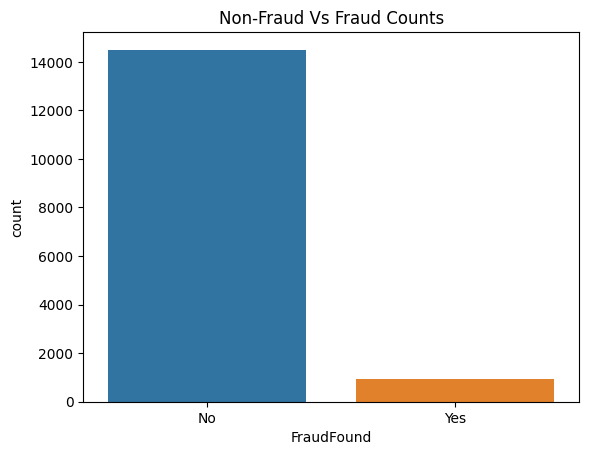

In [ ]:
#check Volume of each classes
sns.countplot(x=df['FraudFound'])
plt.title("Non-Fraud Vs Fraud Counts")
plt.show()

จะเห็นได้ว่า Dataset ของเรามีปัญหา Imbalanced class เป็นอย่างมาก
กล่าวคือ Fraud นั้นคิดเป็นเพียง 5.99% ของ dataset ทั้งหมด

In [ ]:
number_fraud = len(df[df['FraudFound']=='Yes'])
number_fraud

923

In [ ]:
#Check Minority class 
percent = (number_fraud / df.shape[0]) * 100
print(f"fraud detected are {percent:.2f} % of all data points")

fraud detected are 5.99 % of all data points


In [ ]:
#check rows and Columns
print(f"This dataframe contain {df.shape[0]} rows")
print(f"This dataframe contain {df.shape[1]} columns")

This dataframe contain 15420 rows
This dataframe contain 33 columns


In [ ]:
df.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'PolicyNumber', 'RepNumber', 'Deductible',
       'DriverRating', 'Days:Policy-Accident', 'Days:Policy-Claim',
       'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder',
       'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange-Claim', 'NumberOfCars', 'Year',
       'BasePolicy', 'FraudFound'],
      dtype='object')

โดยสรุปแล้ว Dataset ของเรามีทั้งหมด 33 Columns ได้แก่



1. Month เดือนที่เกิดเหตุ 
2. WeekOfMonth วีคที่เกิดอุบัติเหตุมรเดือนจากข้อ 1
3. DayOfWeek วันที่เกิดอุบัติเหตุ
4. AccidentArea พื้นที่เกิดอุบัติเหตุ (Rural, Urban)
5. DayOfWeekClaimed วันทีเคลม
6. MonthClaimed เดือนที่เคลม
7. WeekOfMonthClaimed วีคที่เคลม
8. Sex เพศ
9. MaritalStatus สถานะสมรส
10. Age อายุ
11. Fault ใครเป็นคนผิด
12. PolicyType ประเภทของ Policy
13. VehicleCategory ประเภทของรถ
14. VehiclePrice ราคาของรถ
15. PolicyNumber หมายเลขกรมธรรม์
16. RepNumber หมายเลข Rep
17. Deductible ความรับผิดชอบ
18. DriverRating คะแนนของผู้ขับขี่
19. Days:Policy-Accident 
20. Days:Policy-Claim
21. PastNumberOfClaims จำนวนการเคลมในอดีต
22. AgeOfVehicle อายุของรถ
23. AgeOfPolicyHolder อายุของผู้ถือกรรมธรรม์
24. PolicyReportFiled แจ้งตำรวจ ณ ที่เกิดเหตุหรือไม่
25. WitnessPresent มีพยานหรือไม่
26. AgentType ประเภทของ Agent
27. NumberOfSuppliments จำนวน suppliment
28. AddressChange-Claim จำนวนการเปลี่ยนแปลงที่อยู่ที่ใช้เคลม
29. NumberOfCars จำนวนรถในครอบครอง
30. Year ปีที่เคลม
31. BasePolicy 
32. Make ยี่ห้อรถ
32. FraudFound มีการฉ้อโกงหรือไม่

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  PolicyNumber          15420 non-null

# EDA
ลอง plot graph เปรียบเทียบระหว่างแต่ละ Features ที่มีกับ Label
เพื่อพยายามหา Clue ว่า Features ไหนที่น่าจะสำคัญหรือสัมพันธ์กับ Labels ที่มีบ้าง

<ipython-input-26-407fc1d37529>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True,cmap='coolwarm')


<Axes: >

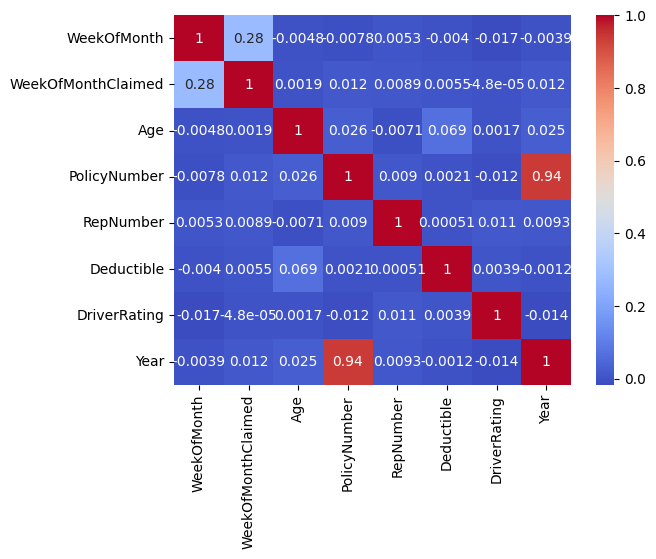

In [ ]:
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')

<Axes: xlabel='Month', ylabel='count'>

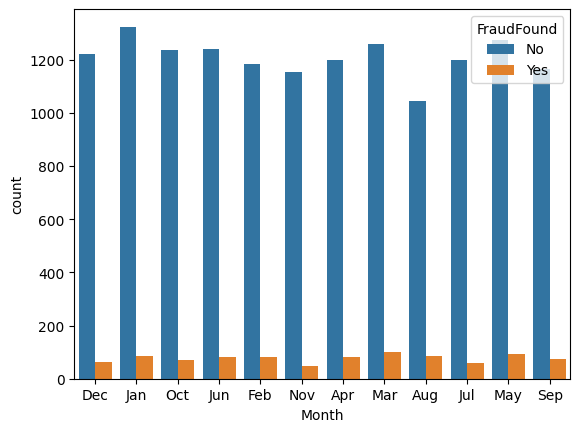

In [ ]:
sns.countplot(data=df, x='Month', hue='FraudFound')

<Axes: xlabel='WeekOfMonth', ylabel='count'>

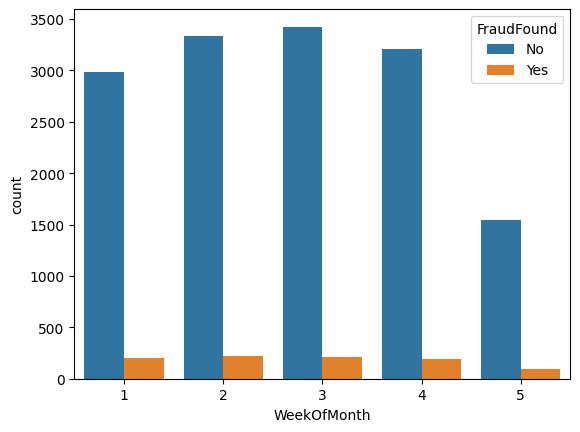

In [ ]:
sns.countplot(data=df, x='WeekOfMonth', hue='FraudFound')

<Axes: xlabel='DayOfWeek', ylabel='count'>

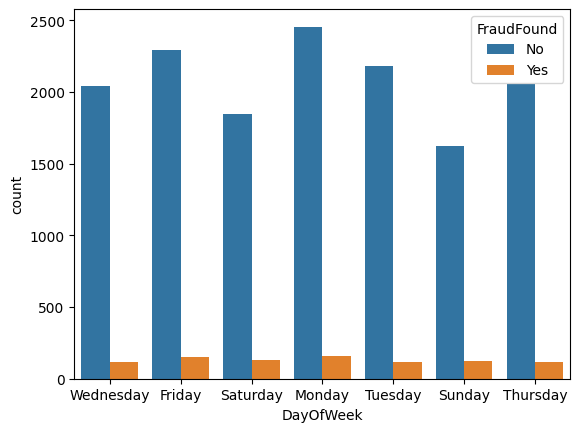

In [ ]:
sns.countplot(data=df, x='DayOfWeek', hue='FraudFound')

<Axes: xlabel='count', ylabel='Make'>

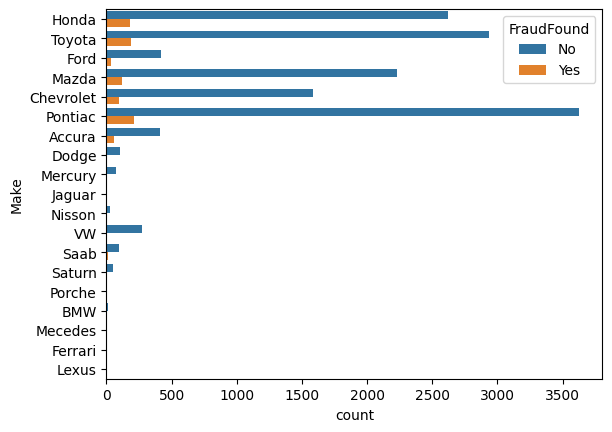

In [ ]:
sns.countplot(data=df, y='Make', hue='FraudFound')

<Axes: xlabel='count', ylabel='AccidentArea'>

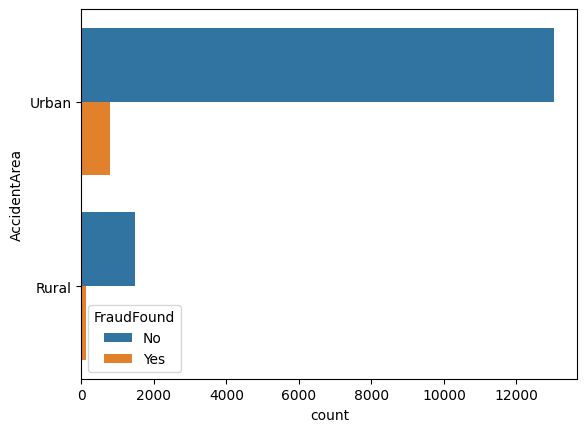

In [ ]:
sns.countplot(data=df, y='AccidentArea', hue='FraudFound')

<Axes: xlabel='count', ylabel='DayOfWeekClaimed'>

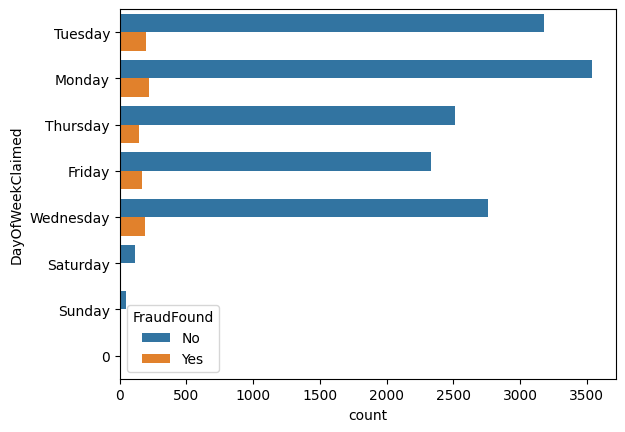

In [ ]:
sns.countplot(data=df, y='DayOfWeekClaimed', hue='FraudFound')

<Axes: xlabel='count', ylabel='MonthClaimed'>

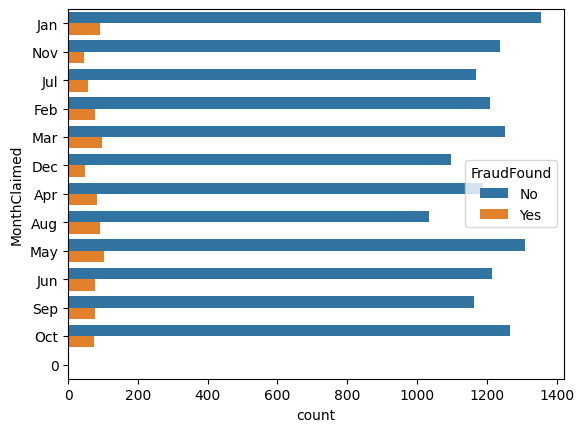

In [ ]:
sns.countplot(data=df, y='MonthClaimed', hue='FraudFound')

<Axes: xlabel='count', ylabel='Sex'>

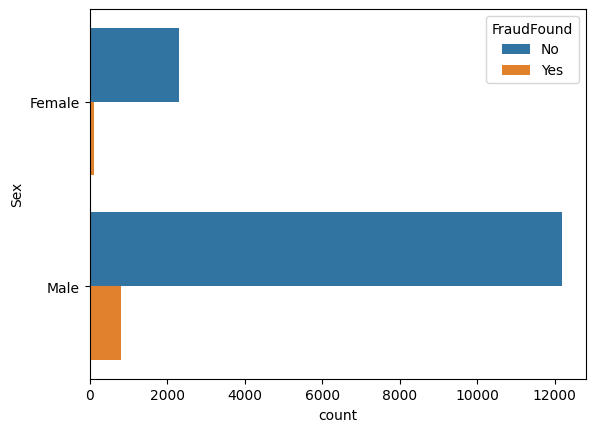

In [ ]:
sns.countplot(data=df, y='Sex', hue='FraudFound')

<Axes: xlabel='count', ylabel='MaritalStatus'>

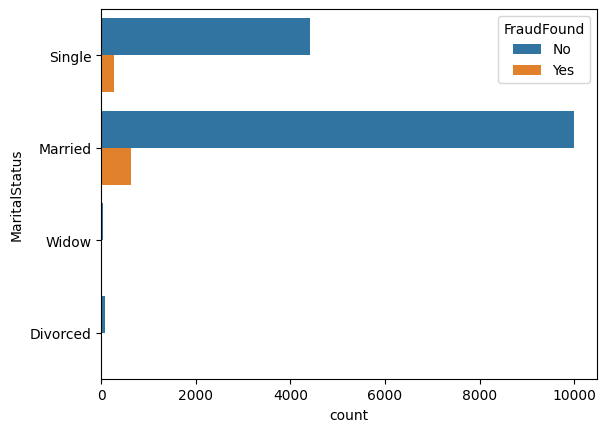

In [ ]:
sns.countplot(data=df, y='MaritalStatus', hue='FraudFound')

<Axes: xlabel='count', ylabel='Fault'>

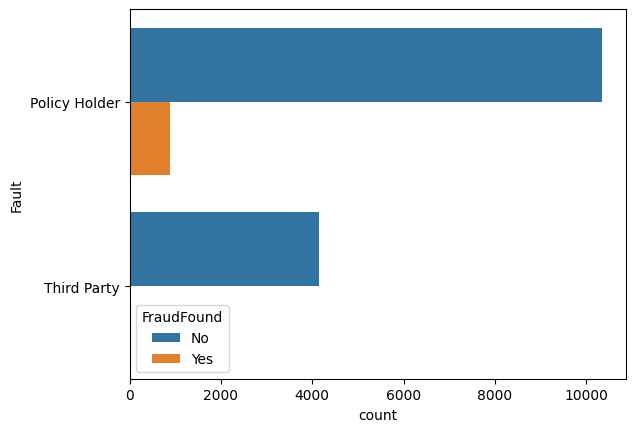

In [ ]:
sns.countplot(data=df, y='Fault', hue='FraudFound')

<Axes: xlabel='count', ylabel='PolicyType'>

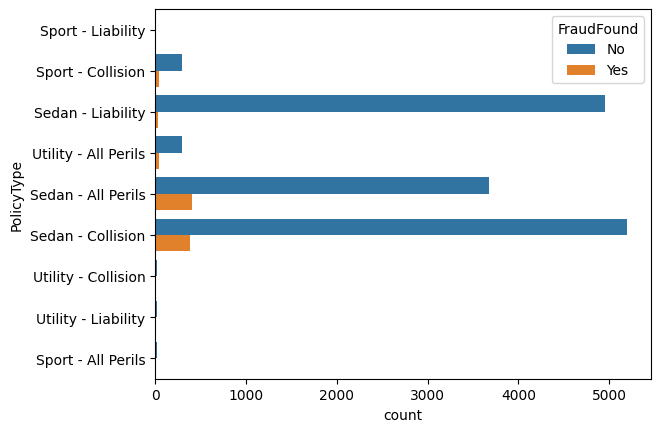

In [ ]:
sns.countplot(data=df, y='PolicyType', hue='FraudFound')

<Axes: xlabel='count', ylabel='VehicleCategory'>

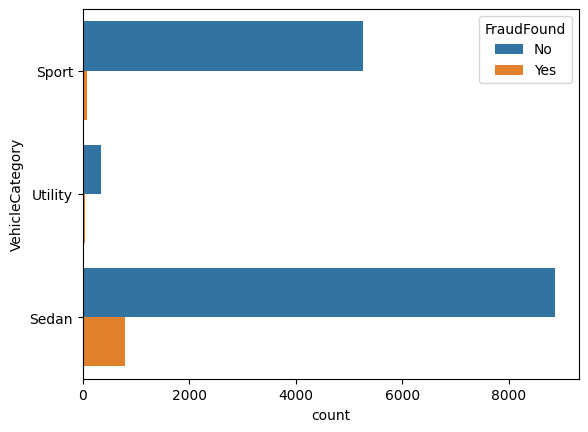

In [ ]:
sns.countplot(data=df, y='VehicleCategory', hue='FraudFound')

<Axes: xlabel='count', ylabel='VehiclePrice'>

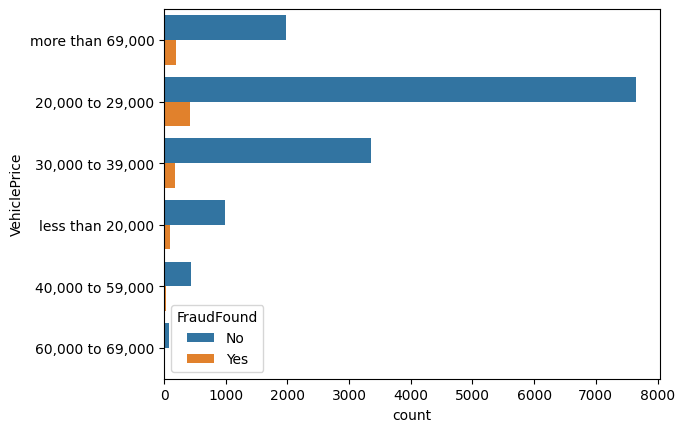

In [ ]:
sns.countplot(data=df, y='VehiclePrice', hue='FraudFound')

<Axes: xlabel='count', ylabel='Deductible'>

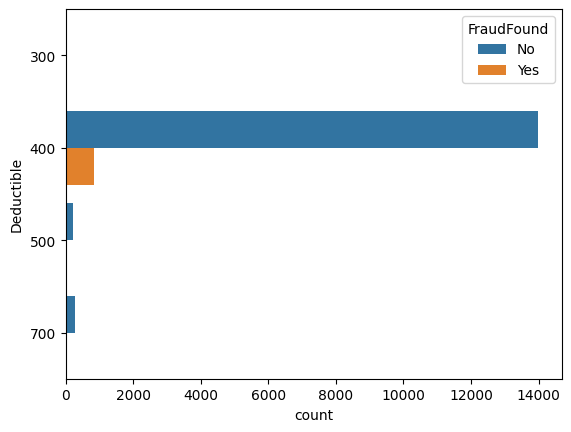

In [ ]:
sns.countplot(data=df, y='Deductible', hue='FraudFound')

<Axes: xlabel='count', ylabel='DriverRating'>

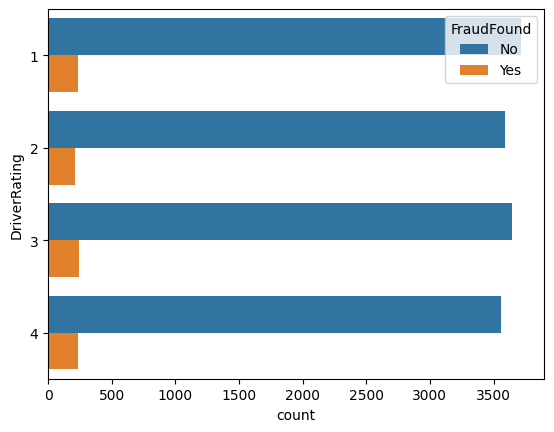

In [ ]:
sns.countplot(data=df, y='DriverRating', hue='FraudFound')

<Axes: xlabel='count', ylabel='Days:Policy-Accident'>

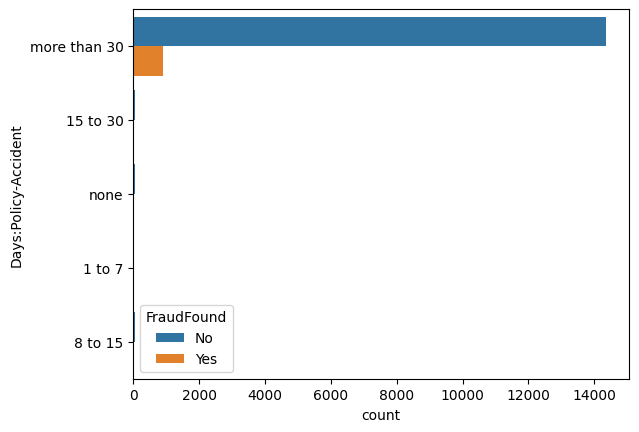

In [ ]:
sns.countplot(data=df, y='Days:Policy-Accident', hue='FraudFound')

<Axes: xlabel='count', ylabel='Days:Policy-Claim'>

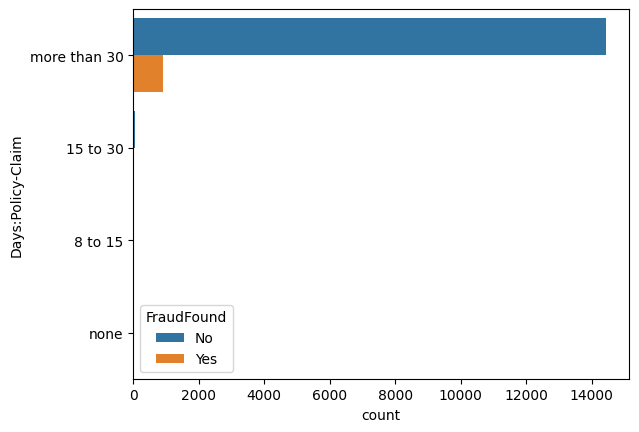

In [ ]:
sns.countplot(data=df, y='Days:Policy-Claim', hue='FraudFound')

<Axes: xlabel='count', ylabel='PastNumberOfClaims'>

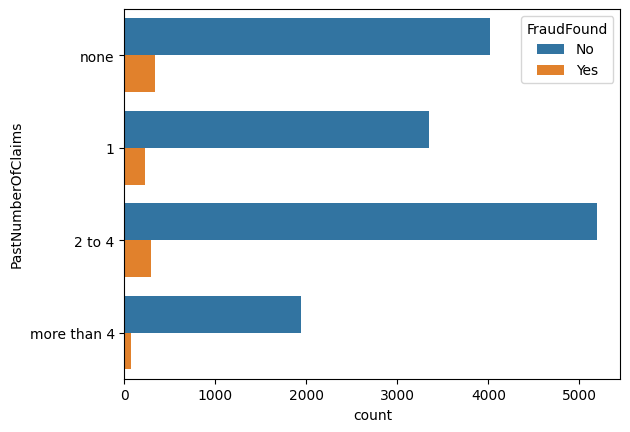

In [ ]:
sns.countplot(data=df, y='PastNumberOfClaims', hue='FraudFound')

<Axes: xlabel='count', ylabel='AgeOfVehicle'>

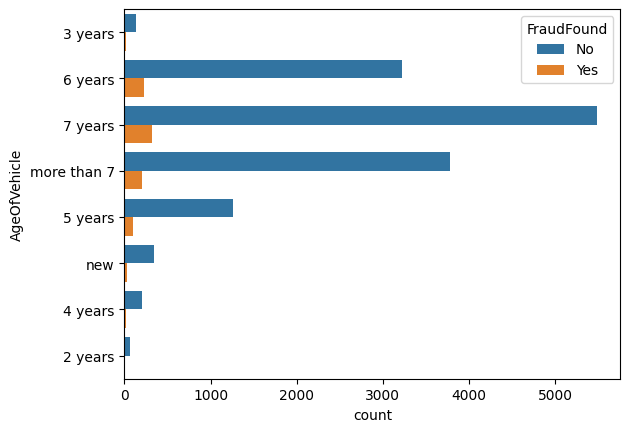

In [ ]:
sns.countplot(data=df, y='AgeOfVehicle', hue='FraudFound')

<Axes: xlabel='count', ylabel='AgeOfPolicyHolder'>

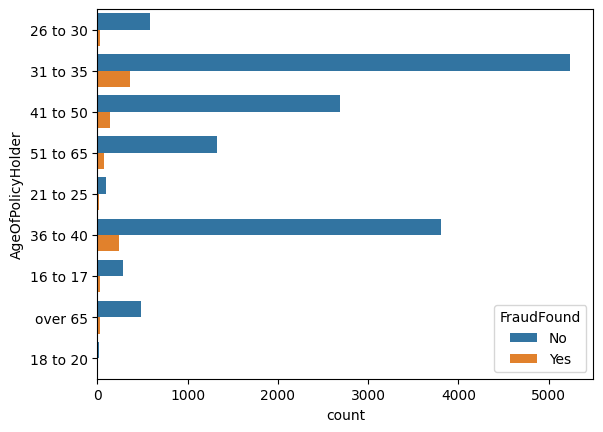

In [ ]:
sns.countplot(data=df, y='AgeOfPolicyHolder', hue='FraudFound')

<Axes: xlabel='count', ylabel='PoliceReportFiled'>

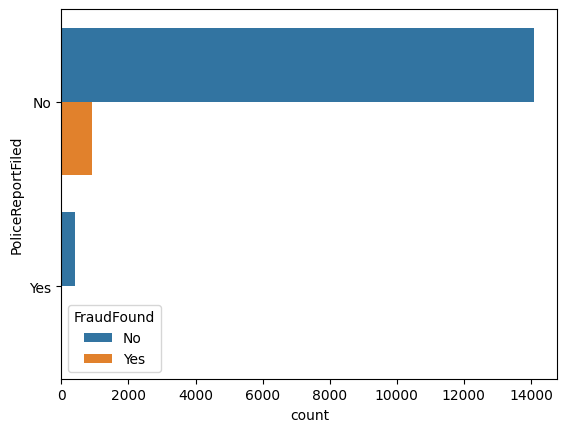

In [ ]:
sns.countplot(data=df, y='PoliceReportFiled', hue='FraudFound')

<Axes: xlabel='count', ylabel='WitnessPresent'>

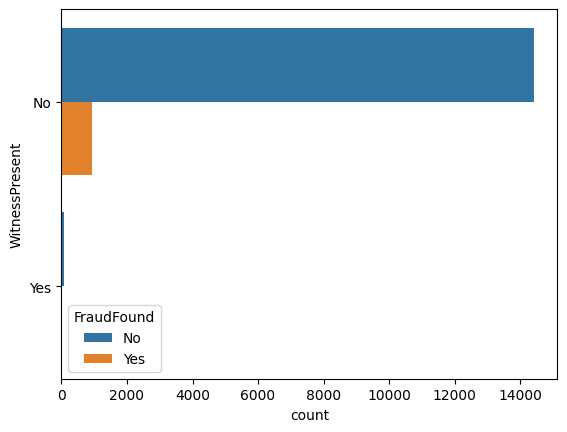

In [ ]:
sns.countplot(data=df, y='WitnessPresent', hue='FraudFound')

<Axes: xlabel='count', ylabel='AgentType'>

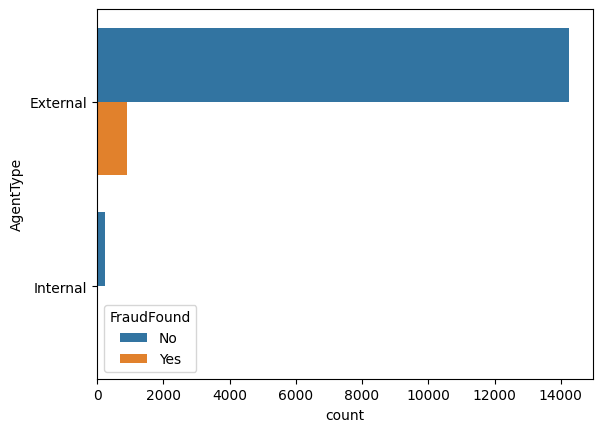

In [ ]:
sns.countplot(data=df, y='AgentType', hue='FraudFound')

<Axes: xlabel='count', ylabel='NumberOfSuppliments'>

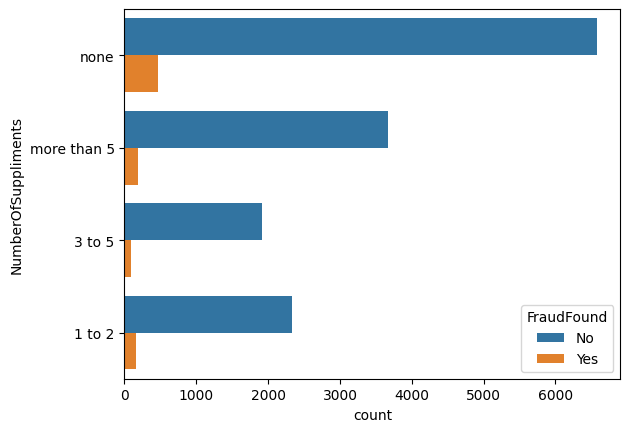

In [ ]:
sns.countplot(data=df, y='NumberOfSuppliments', hue='FraudFound')

<Axes: xlabel='count', ylabel='AddressChange-Claim'>

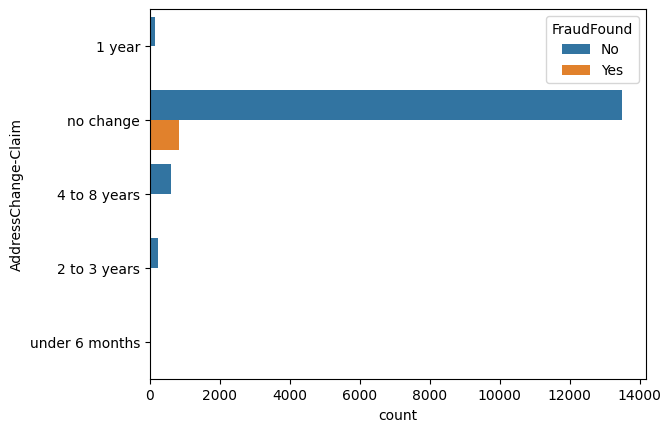

In [ ]:
sns.countplot(data=df, y='AddressChange-Claim', hue='FraudFound')

<Axes: xlabel='count', ylabel='NumberOfCars'>

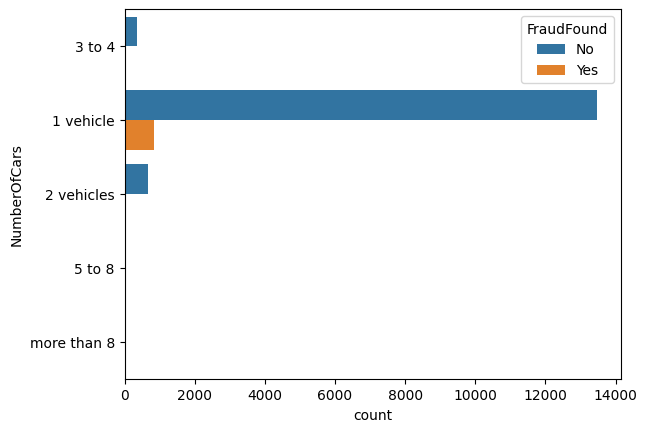

In [ ]:
sns.countplot(data=df, y='NumberOfCars', hue='FraudFound')

<Axes: xlabel='count', ylabel='Year'>

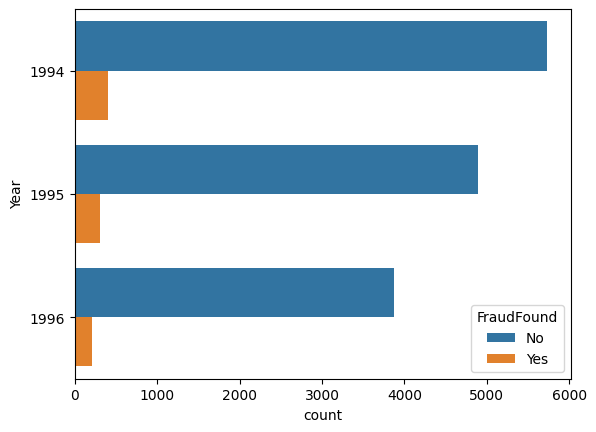

In [ ]:
sns.countplot(data=df, y='Year', hue='FraudFound')

<Axes: xlabel='count', ylabel='BasePolicy'>

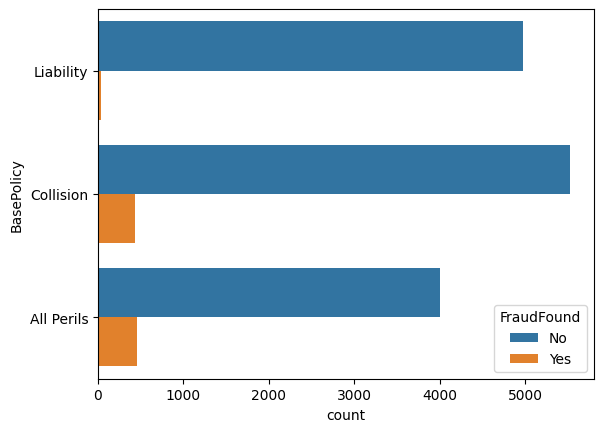

In [ ]:
sns.countplot(data=df, y='BasePolicy', hue='FraudFound')

# Preprocessing
เนื่องจากดูเหมือนว่า Data ของเรามีข้อมูลที่เป็น Category และมี Features 

ที่ซ้ำซ้อนกันอยู่ จะมาลด Features ที่ซ้ำซ้อนและจัดการเปลี่ยน type ของ data 

เพื่อนำไป Train Model ต่อไป

### Drop redundant features


*   "PolicyNumber" , It's an ID number 
*   "AgeOfPolicyHolder" , Redundant with Age
*   "BasePolicy" , Redundant with PolicyType







In [ ]:
df.head(1)

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy,FraudFound
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,No


In [ ]:
df.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'PolicyNumber', 'RepNumber', 'Deductible',
       'DriverRating', 'Days:Policy-Accident', 'Days:Policy-Claim',
       'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder',
       'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange-Claim', 'NumberOfCars', 'Year',
       'BasePolicy', 'FraudFound'],
      dtype='object')

In [ ]:
#check 2 columns that contain the same values
df[['AgeOfPolicyHolder','Age']]

,AgeOfPolicyHolder,Age
0,26 to 30,21
1,31 to 35,34
2,41 to 50,47
3,51 to 65,65
4,31 to 35,27
...,...,...
15415,31 to 35,35
15416,31 to 35,30
15417,26 to 30,24
15418,31 to 35,34


In [ ]:
#Contained the same values again
df[['BasePolicy', 'PolicyType']]

,BasePolicy,PolicyType
0,Liability,Sport - Liability
1,Collision,Sport - Collision
2,Collision,Sport - Collision
3,Liability,Sedan - Liability
4,Collision,Sport - Collision
...,...,...
15415,Collision,Sedan - Collision
15416,Liability,Sedan - Liability
15417,Collision,Sedan - Collision
15418,All Perils,Sedan - All Perils


In [ ]:
#make list that contained name of unwated columns or redundancy columns
unwanted_features = ['PolicyNumber', 'AgeOfPolicyHolder', 'BasePolicy', 'VehicleCategory']

In [ ]:
#drop unwanted columns
df_new = df.drop(unwanted_features, axis=1)

In [ ]:
df_drop = df_new.copy()

### One Hot Encoding

In [ ]:
df_onehot = df_new.copy()

In [ ]:
#collected name of Categorical features
categorical_fetures = [x for x in df_onehot.columns if df_onehot[x].dtype != "int64"]

In [ ]:
#Then remove Labels from list
categorical_fetures.remove('FraudFound')
categorical_fetures

['Month',
 'DayOfWeek',
 'Make',
 'AccidentArea',
 'DayOfWeekClaimed',
 'MonthClaimed',
 'Sex',
 'MaritalStatus',
 'Fault',
 'PolicyType',
 'VehiclePrice',
 'Days:Policy-Accident',
 'Days:Policy-Claim',
 'PastNumberOfClaims',
 'AgeOfVehicle',
 'PoliceReportFiled',
 'WitnessPresent',
 'AgentType',
 'NumberOfSuppliments',
 'AddressChange-Claim',
 'NumberOfCars']

In [ ]:
#change type from Obj to categorical
for cat in categorical_fetures:
  dummies = pd.get_dummies(df[cat])
  df_onehot = pd.concat([df_onehot, dummies], axis=1) 
  df_onehot.drop(cat, axis=1, inplace=True)

In [ ]:
df_onehot

,WeekOfMonth,WeekOfMonthClaimed,Age,RepNumber,Deductible,DriverRating,Year,FraudFound,Apr,Aug,...,1 year,2 to 3 years,4 to 8 years,no change,under 6 months,1 vehicle,2 vehicles,3 to 4,5 to 8,more than 8
0,5,1,21,12,300,1,1994,No,0,0,...,1,0,0,0,0,0,0,1,0,0
1,3,4,34,15,400,4,1994,No,0,0,...,0,0,0,1,0,1,0,0,0,0
2,5,2,47,7,400,3,1994,No,0,0,...,0,0,0,1,0,1,0,0,0,0
3,2,1,65,4,400,2,1994,No,0,0,...,0,0,0,1,0,1,0,0,0,0
4,5,2,27,3,400,1,1994,No,0,0,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,4,5,35,5,400,4,1996,Yes,0,0,...,0,0,0,1,0,1,0,0,0,0
15416,5,1,30,11,400,3,1996,No,0,0,...,0,0,0,1,0,0,0,1,0,0
15417,5,1,24,4,400,4,1996,Yes,0,0,...,0,0,0,1,0,1,0,0,0,0
15418,1,2,34,6,400,4,1996,No,0,0,...,0,0,0,1,0,1,0,0,0,0


In [ ]:
#replace str label with numerical label
df_onehot['FraudFound'].replace({"No":0,"Yes":1}, inplace=True)

In [ ]:
df_onehot['FraudFound'].unique()

array([0, 1])

In [ ]:
y_onehot = df_onehot[['FraudFound']]
X_onehot = df_onehot.drop('FraudFound', axis=1)

In [ ]:
y_onehot['FraudFound'].apply(lambda x: 0 if x=="No" else 1)

0        1
1        1
2        1
3        1
4        1
        ..
15415    1
15416    1
15417    1
15418    1
15419    1
Name: FraudFound, Length: 15420, dtype: int64

### Change Categorical to number

In [ ]:
df_drop.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehiclePrice',
       'RepNumber', 'Deductible', 'DriverRating', 'Days:Policy-Accident',
       'Days:Policy-Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange-Claim', 'NumberOfCars', 'Year',
       'FraudFound'],
      dtype='object')

In [ ]:
df_drop['Month'].unique()

array(['Dec', 'Jan', 'Oct', 'Jun', 'Feb', 'Nov', 'Apr', 'Mar', 'Aug',
       'Jul', 'May', 'Sep'], dtype=object)

In [ ]:
df_drop['Make'].unique()

array(['Honda', 'Toyota', 'Ford', 'Mazda', 'Chevrolet', 'Pontiac',
       'Accura', 'Dodge', 'Mercury', 'Jaguar', 'Nisson', 'VW', 'Saab',
       'Saturn', 'Porche', 'BMW', 'Mecedes', 'Ferrari', 'Lexus'],
      dtype=object)

In [ ]:
df_drop['AccidentArea'].unique()

array(['Urban', 'Rural'], dtype=object)

In [ ]:
df_drop['Sex'].unique()

array(['Female', 'Male'], dtype=object)

In [ ]:
df_drop['MaritalStatus'].unique()

array(['Single', 'Married', 'Widow', 'Divorced'], dtype=object)

In [ ]:
df_drop['Fault'].unique()

array(['Policy Holder', 'Third Party'], dtype=object)

In [ ]:
df_drop['PolicyType'].unique()

array(['Sport - Liability', 'Sport - Collision', 'Sedan - Liability',
       'Utility - All Perils', 'Sedan - All Perils', 'Sedan - Collision',
       'Utility - Collision', 'Utility - Liability', 'Sport - All Perils'],
      dtype=object)

In [ ]:
df_drop['VehiclePrice'].unique()

array(['more than 69,000', '20,000 to 29,000', '30,000 to 39,000',
       'less than 20,000', '40,000 to 59,000', '60,000 to 69,000'],
      dtype=object)

In [ ]:
df_drop['Days:Policy-Accident'].unique()

array(['more than 30', '15 to 30', 'none', '1 to 7', '8 to 15'],
      dtype=object)

In [ ]:
df_drop['Days:Policy-Claim'].unique()

array(['more than 30', '15 to 30', '8 to 15', 'none'], dtype=object)

In [ ]:
df_drop['PastNumberOfClaims'].unique()

array(['none', '1', '2 to 4', 'more than 4'], dtype=object)

In [ ]:
df_drop['AgeOfVehicle'].unique()

array(['3 years', '6 years', '7 years', 'more than 7', '5 years', 'new',
       '4 years', '2 years'], dtype=object)

In [ ]:
df_drop['PoliceReportFiled'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
df_drop['WitnessPresent'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
df_drop['AgentType'].unique()

array(['External', 'Internal'], dtype=object)

In [ ]:
df_drop['NumberOfSuppliments'].unique()

array(['none', 'more than 5', '3 to 5', '1 to 2'], dtype=object)

In [ ]:
df_drop['AddressChange-Claim'].unique()

array(['1 year', 'no change', '4 to 8 years', '2 to 3 years',
       'under 6 months'], dtype=object)

In [ ]:
df_drop['NumberOfCars'].unique()

array(['3 to 4', '1 vehicle', '2 vehicles', '5 to 8', 'more than 8'],
      dtype=object)

In [ ]:
cath_features = []
for name in df_drop.columns:
  if df_drop[name].dtype != "int64":
    cath_features.append(name)

In [ ]:
cath_features

['Month',
 'DayOfWeek',
 'Make',
 'AccidentArea',
 'DayOfWeekClaimed',
 'MonthClaimed',
 'Sex',
 'MaritalStatus',
 'Fault',
 'PolicyType',
 'VehiclePrice',
 'Days:Policy-Accident',
 'Days:Policy-Claim',
 'PastNumberOfClaims',
 'AgeOfVehicle',
 'PoliceReportFiled',
 'WitnessPresent',
 'AgentType',
 'NumberOfSuppliments',
 'AddressChange-Claim',
 'NumberOfCars',
 'FraudFound']

In [ ]:
#Creat Dictionary
Month = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
DayOfWeek = {'Sunday':1,'Monday':2,'Tuesday':3,'Wednesday':4,'Thursday':5,'Friday':6,'Saturday':7}
Make = {'Honda':1, 'Toyota':2, 'Ford':3, 'Mazda':4, 'Chevrolet':5, 'Pontiac':6,
       'Accura':7, 'Dodge':8, 'Mercury':9, 'Jaguar':10, 'Nisson':11, 'VW':12, 'Saab':13,
       'Saturn':14, 'Porche':15, 'BMW':16, 'Mecedes':17, 'Ferrari':18, 'Lexus':19}
AccidentArea = {'Urban' : 0, "Rural": 1}
Sex = {'Female' : 0, "Male": 1}
MaritalStatus = {'Single':1,'Married':2,'Widow':3, 'Divorced':4}
Fault = {'Policy Holder':0, "Third Party":1}
PolicyType = {'Sport - Liability':0, 'Sport - Collision':1, 'Sedan - Liability':2,
       'Utility - All Perils':3, 'Sedan - All Perils':4, 'Sedan - Collision':5,
       'Utility - Collision':6, 'Utility - Liability':7, 'Sport - All Perils':8}
VehiclePrice = {'more than 69,000':0, '20,000 to 29,000':1, '30,000 to 39,000':2,
       'less than 20,000':3, '40,000 to 59,000':4, '60,000 to 69,000':5}
Days_Policy_Accident = {'more than 30':2, '15 to 30':1, 'none':0, '1 to 7':3, '8 to 15':4}
Days_Policy_Claim = {'more than 30':2, '15 to 30':1, '8 to 15':3, 'none':0}
PastNumberOfClaims = {'none':0, '1':1, '2 to 4':2, 'more than 4':3}
AgeOfVehicle = {'3 years':2, '6 years':5, '7 years':6, 'more than 7':7, '5 years':4, 'new':0,
       '4 years':3, '2 years':1}
PoliceReportFiled = {'No':0, "Yes":1}
WitnessPresent = {'No':0, "Yes":1}
AgentType = {'External':0, 'Internal':1}
NumberOfSuppliments = {'none':0, 'more than 5':3, '3 to 5':2, '1 to 2':1}
AddressChange_Claim = {'1 year':2, 'no change':0, '4 to 8 years':4, '2 to 3 years':3,
       'under 6 months':1}
NumberOfCars = {'3 to 4':2, '1 vehicle' :0, '2 vehicles':1, '5 to 8':3, 'more than 8':4}
FraudFound = {'No':0, "Yes":1}

In [ ]:
#replace with Dcitionary
df_drop['Month'].replace(Month, inplace =True)
df_drop['MonthClaimed'].replace(Month, inplace =True)
df_drop['DayOfWeekClaimed'].replace(DayOfWeek, inplace =True)
df_drop['DayOfWeek'].replace(DayOfWeek, inplace =True)
df_drop['Make'].replace(Make, inplace =True)
df_drop['AccidentArea'].replace(AccidentArea, inplace =True)
df_drop['Sex'].replace(Sex, inplace =True)
df_drop['MaritalStatus'].replace(MaritalStatus, inplace =True)
df_drop['Fault'].replace(Fault, inplace =True)
df_drop['PolicyType'].replace(PolicyType, inplace =True)
df_drop['VehiclePrice'].replace(VehiclePrice, inplace =True)
df_drop['Days:Policy-Accident'].replace(Days_Policy_Accident, inplace =True)
df_drop['Days:Policy-Claim'].replace(Days_Policy_Claim, inplace =True)
df_drop['PastNumberOfClaims'].replace(PastNumberOfClaims, inplace =True)
df_drop['AgeOfVehicle'].replace(AgeOfVehicle, inplace =True)
df_drop['PoliceReportFiled'].replace(PoliceReportFiled, inplace =True)
df_drop['WitnessPresent'].replace(WitnessPresent, inplace =True)
df_drop['AgentType'].replace(AgentType, inplace =True)
df_drop['NumberOfSuppliments'].replace(NumberOfSuppliments, inplace =True)
df_drop['AddressChange-Claim'].replace(AddressChange_Claim, inplace =True)
df_drop['NumberOfCars'].replace(NumberOfCars, inplace =True)
df_drop['FraudFound'].replace(FraudFound, inplace =True)

In [ ]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  int64 
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  int64 
 3   Make                  15420 non-null  int64 
 4   AccidentArea          15420 non-null  int64 
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  int64 
 9   MaritalStatus         15420 non-null  int64 
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  int64 
 12  PolicyType            15420 non-null  int64 
 13  VehiclePrice          15420 non-null  int64 
 14  RepNumber             15420 non-null  int64 
 15  Deductible            15420 non-null

In [ ]:
df_drop['DayOfWeekClaimed'].astype(int)

0        3
1        2
2        5
3        6
4        3
        ..
15415    3
15416    6
15417    6
15418    5
15419    5
Name: DayOfWeekClaimed, Length: 15420, dtype: int64

In [ ]:
df_drop['MonthClaimed'].astype(int)

0         1
1         1
2        11
3         7
4         2
         ..
15415    11
15416    12
15417    12
15418    12
15419    12
Name: MonthClaimed, Length: 15420, dtype: int64

In [ ]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  int64 
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  int64 
 3   Make                  15420 non-null  int64 
 4   AccidentArea          15420 non-null  int64 
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  int64 
 9   MaritalStatus         15420 non-null  int64 
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  int64 
 12  PolicyType            15420 non-null  int64 
 13  VehiclePrice          15420 non-null  int64 
 14  RepNumber             15420 non-null  int64 
 15  Deductible            15420 non-null

### Feture Engineering

ใน section นี้ตั้งใจอยากจะสร้าง Feture ใหม่ที่เป็นการหาระยะห่างจากวันที่เกิดเหตุและวันเคลม แต่เนื่องจาก Dataset ไม่ได้ Provide ปีที่เกิดเหตุมาให้จึงอาจทำให้ข้อมูลผิดพลาดจึงเลือกจะไม่ทำเพิ่ม

In [ ]:
df.head(3)

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy,FraudFound
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,No
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision,No
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision,No


In [ ]:
df_1994 = df[df['Year']==1994]

In [ ]:
test = df.copy()

In [ ]:
test.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'PolicyNumber', 'RepNumber', 'Deductible',
       'DriverRating', 'Days:Policy-Accident', 'Days:Policy-Claim',
       'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder',
       'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange-Claim', 'NumberOfCars', 'Year',
       'BasePolicy', 'FraudFound'],
      dtype='object')

In [ ]:
test[['WeekOfMonth','Month','DayOfWeek','DayOfWeekClaimed','MonthClaimed','WeekOfMonthClaimed','Year']]

,WeekOfMonth,Month,DayOfWeek,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Year
0,5,Dec,Wednesday,Tuesday,Jan,1,1994
1,3,Jan,Wednesday,Monday,Jan,4,1994
2,5,Oct,Friday,Thursday,Nov,2,1994
3,2,Jun,Saturday,Friday,Jul,1,1994
4,5,Jan,Monday,Tuesday,Feb,2,1994
...,...,...,...,...,...,...,...
15415,4,Nov,Friday,Tuesday,Nov,5,1996
15416,5,Nov,Thursday,Friday,Dec,1,1996
15417,5,Nov,Thursday,Friday,Dec,1,1996
15418,1,Dec,Monday,Thursday,Dec,2,1996


In [ ]:
from datetime import datetime

In [ ]:
month_acc = list(test['Month'])
len(month_acc)

15420

In [ ]:
#หมด Idea ขอติดไว้ก่อน!!!

# Modeling
ใน Section นี้จะนำข้อมูลที่เตรียมเอาไว้มา Train Model 

โดยแต่ละ model ที่เลือกใช้จะใช้ร่วมกับเทคนิดในการแก้ปัญหา 
Imbalanced Data 3 วิธีดังนี้

1.   XGBoost Classification      
        *   SMOTE
        *   RandomOverSampling
        *   RandomUnderSampling


2.   KNN Classification
        *   SMOTE
        *   RandomOverSampling
        *   RandomUnderSampling
3.   Logistic Regression
        *   SMOTE
        *   RandomOverSampling
        *   RandomUnderSampling


### XGB

In [ ]:
df_xgb = df_new.copy()


In [ ]:
df_xgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehiclePrice          15420 non-null  object
 14  RepNumber             15420 non-null  int64 
 15  Deductible            15420 non-null

In [ ]:
df_xgb['FraudFound'].replace({'No':0,'Yes':1},inplace=True)

In [ ]:
from pandas.core.dtypes.common import is_string_dtype
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [ ]:
train_cats(df_xgb)

In [ ]:
y = df_xgb[['FraudFound']]
X = df_xgb.drop('FraudFound', axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99,
                                                    stratify=y)

Text(0.5, 1.0, 'Not-Fraud VS Fraud')

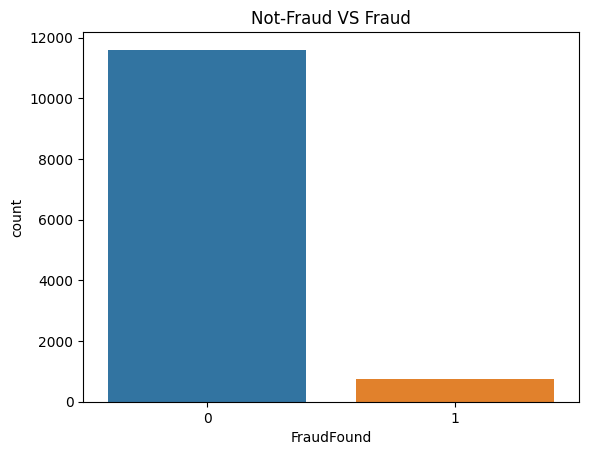

In [ ]:
sns.countplot(x=y_train['FraudFound'])
plt.title("Not-Fraud VS Fraud")

In [ ]:
import xgboost as xgb
XGB = xgb.XGBClassifier(eta=0.1, gamma=1, max_depth=5, enable_categorical=True,
                       tree_method='gpu_hist', n_estimators=1000,
                       reg_alpha=0.005)

In [ ]:
XGB.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.1, eval_metric=None,
              feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
scores = cross_val_score(XGB, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.94084279 0.94165316 0.94165316 0.94165316 0.94327391 0.94084279
 0.9432279  0.9432279  0.94241687 0.94160584]
Mean: 0.9420397470427636
Standard Deviation: 0.0008939143492269182


In [ ]:
y_pred = XGB.predict(X_test)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2899
           1       1.00      0.04      0.07       185

    accuracy                           0.94      3084
   macro avg       0.97      0.52      0.52      3084
weighted avg       0.95      0.94      0.92      3084



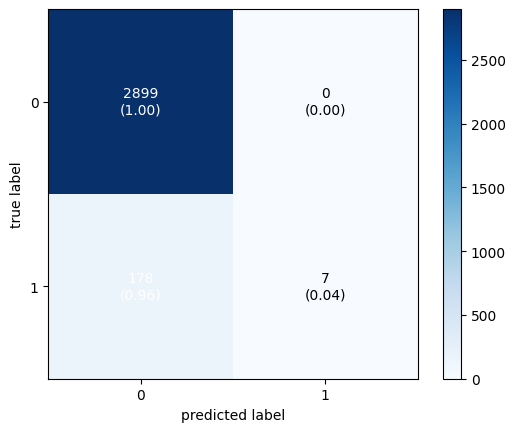

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
print(classification_report(y_test, y_pred))
cm1 = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

#### Undersampling method

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
ros = RandomUnderSampler(random_state=99)
X_undersam, y_undersam = ros.fit_resample(X_train, y_train)

Text(0.5, 1.0, 'Fraud Vs Not-Fraud \n with Unsersampling')

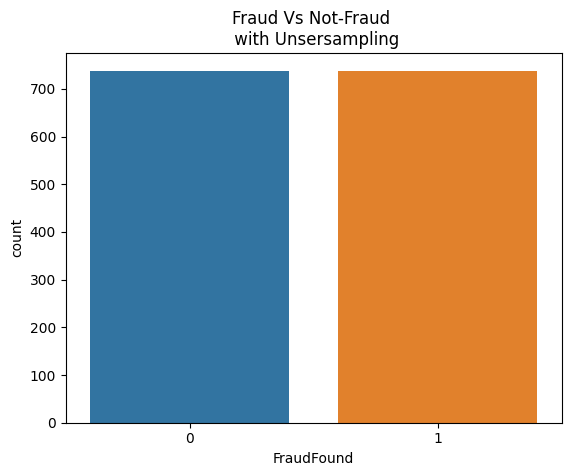

In [ ]:
sns.countplot(x=y_undersam['FraudFound'])
plt.title("Fraud Vs Not-Fraud \n with Unsersampling")

In [ ]:
import xgboost as xgb
XGB = xgb.XGBClassifier(eta=0.1, gamma=3, max_depth=10, enable_categorical=True,
                       tree_method='gpu_hist', n_estimators=1000,
                       reg_alpha=0.005, validate_parameters=True)
XGB.fit(X_undersam, y_undersam)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.1, eval_metric=None,
              feature_types=None, gamma=3, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

<Axes: >

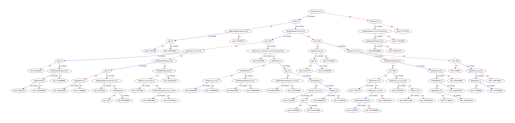

In [ ]:
xgb.plot_tree(XGB)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

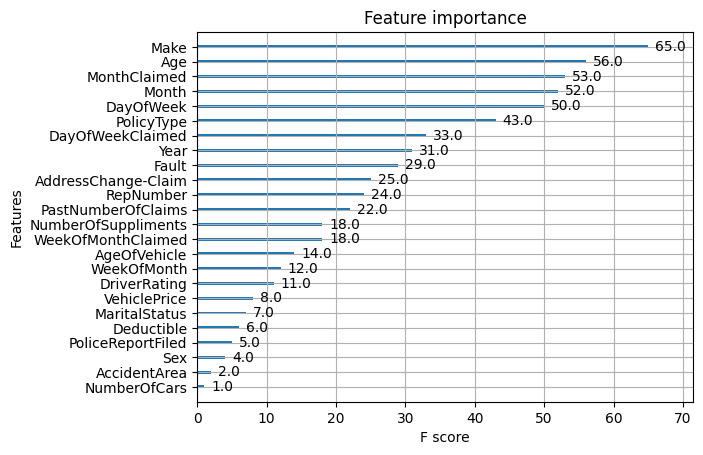

In [ ]:
xgb.plot_importance(XGB)

In [ ]:
scores = cross_val_score(XGB, X_undersam, y_undersam, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.79054054 0.77702703 0.72972973 0.78378378 0.75       0.77027027
 0.78911565 0.80952381 0.72789116 0.78911565]
Mean: 0.7716997609854752
Standard Deviation: 0.025923471095919554


In [ ]:
y_pred_under = XGB.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      0.64      0.78      2899
           1       0.14      0.90      0.24       185

    accuracy                           0.66      3084
   macro avg       0.56      0.77      0.51      3084
weighted avg       0.94      0.66      0.75      3084



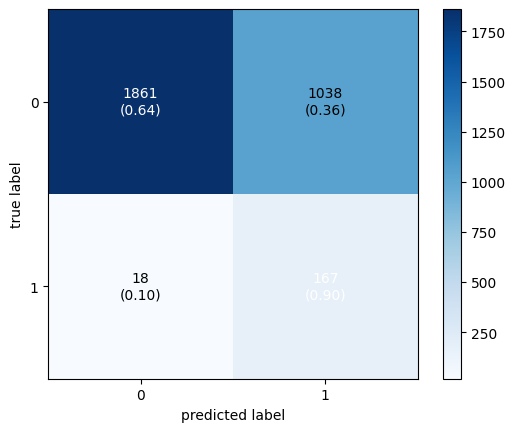

In [ ]:
print(classification_report(y_test, y_pred_under))
cm1 = confusion_matrix(y_test,y_pred_under)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

#### Oversampling Method

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
ros = RandomOverSampler(random_state=99)
X_oversam, y_oversam = ros.fit_resample(X_train, y_train)

Text(0.5, 1.0, 'Fraud Vs Not-Fraud \n with Oversampling')

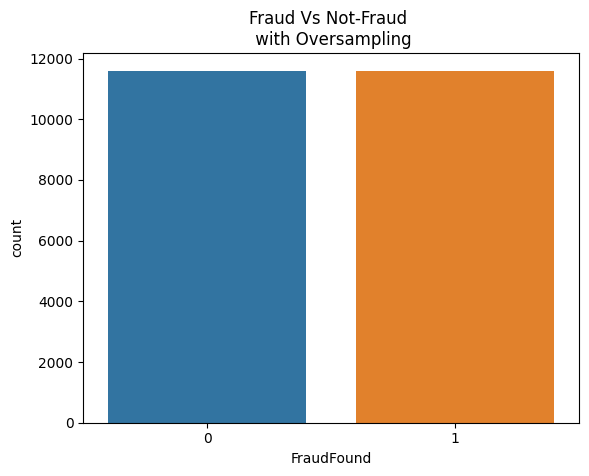

In [ ]:
sns.countplot(x=y_oversam['FraudFound'])
plt.title("Fraud Vs Not-Fraud \n with Oversampling")

In [ ]:
import xgboost as xgb
XGB = xgb.XGBClassifier(eta=0.1, gamma=3, max_depth=10, enable_categorical=True,
                       tree_method='gpu_hist', n_estimators=100,
                       reg_alpha=0.005)
XGB.fit(X_oversam, y_oversam)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.1, eval_metric=None,
              feature_types=None, gamma=3, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
scores = cross_val_score(XGB, X_oversam, y_oversam, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.95086207 0.9487069  0.94310345 0.94956897 0.94439655 0.9487069
 0.93790427 0.949116   0.93488573 0.93661061]
Mean: 0.9443861429569822
Standard Deviation: 0.005682302167690673


In [ ]:
y_pred_over = XGB.predict(X_test)

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      2899
           1       0.22      0.44      0.29       185

    accuracy                           0.87      3084
   macro avg       0.59      0.67      0.61      3084
weighted avg       0.92      0.87      0.89      3084



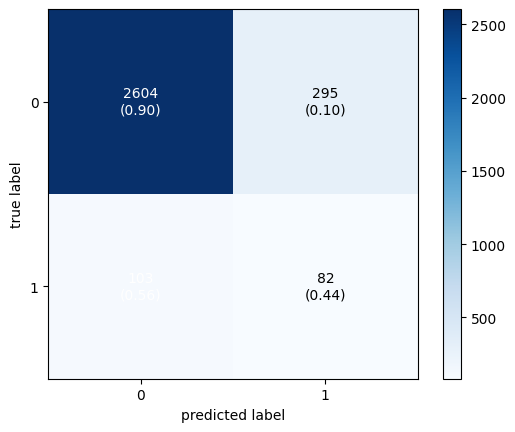

In [ ]:
print(classification_report(y_test, y_pred_over))
cm1 = confusion_matrix(y_test,y_pred_over)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

#### SMOTENC

In [ ]:
df_xgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Month                 15420 non-null  category
 1   WeekOfMonth           15420 non-null  int64   
 2   DayOfWeek             15420 non-null  category
 3   Make                  15420 non-null  category
 4   AccidentArea          15420 non-null  category
 5   DayOfWeekClaimed      15420 non-null  category
 6   MonthClaimed          15420 non-null  category
 7   WeekOfMonthClaimed    15420 non-null  int64   
 8   Sex                   15420 non-null  category
 9   MaritalStatus         15420 non-null  category
 10  Age                   15420 non-null  int64   
 11  Fault                 15420 non-null  category
 12  PolicyType            15420 non-null  category
 13  VehiclePrice          15420 non-null  category
 14  RepNumber             15420 non-null  int64   
 15  De

In [ ]:
from imblearn.over_sampling import SMOTENC

In [ ]:
sm = SMOTENC(k_neighbors=5,random_state=99, categorical_features=[0,2,3,4,5,6,8,9,11,12,13,
                                                   17,18,19,20,21,22,23,24,25,26])

In [ ]:
X_smote, y_smote = sm.fit_resample(X_train, y_train)

Text(0.5, 1.0, 'Fraud Vs Not-Fraud \n with SMOTENC')

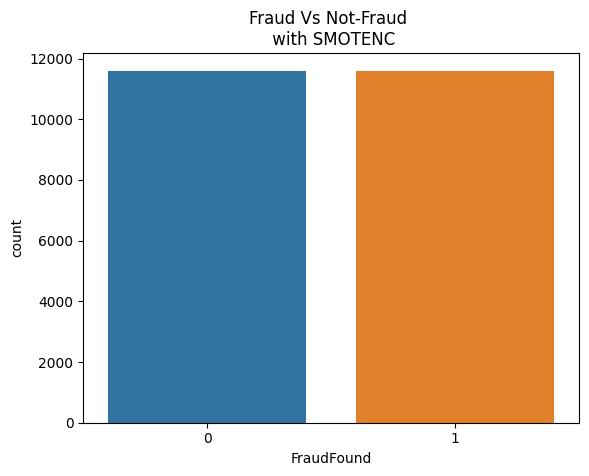

In [ ]:
sns.countplot(x=y_smote['FraudFound'])
plt.title("Fraud Vs Not-Fraud \n with SMOTENC")

In [ ]:
XGB = xgb.XGBClassifier(eta=0.1, gamma=3, max_depth=10, enable_categorical=True,
                       tree_method='gpu_hist', n_estimators=100,
                       reg_alpha=0.005)
XGB.fit(X_smote, y_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.1, eval_metric=None,
              feature_types=None, gamma=3, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
scores = cross_val_score(XGB, X_smote, y_smote, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.77801724 0.93836207 0.94310345 0.93405172 0.94612069 0.94482759
 0.93488573 0.94049159 0.93445451 0.93962915]
Mean: 0.9233943733178689
Standard Deviation: 0.04862787042968677


In [ ]:
y_pred_smote = XGB.predict(X_test)

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      2899
           1       0.19      0.37      0.25       185

    accuracy                           0.86      3084
   macro avg       0.57      0.63      0.59      3084
weighted avg       0.91      0.86      0.88      3084



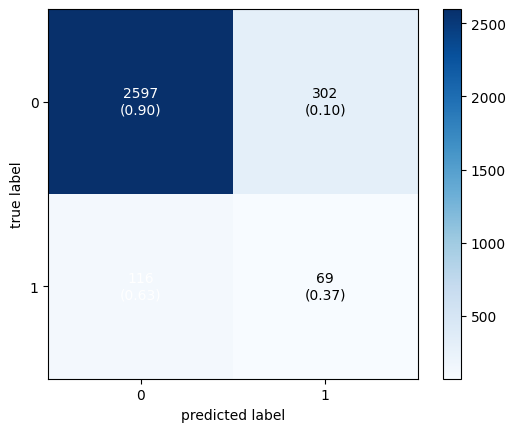

In [ ]:
print(classification_report(y_test, y_pred_smote))
cm1 = confusion_matrix(y_test,y_pred_smote)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

In [ ]:
print(XGB.feature_importances_)

[0.00920868 0.00898996 0.00626836 0.00826224 0.01423987 0.00630557
 0.00930757 0.00993399 0.17689742 0.00788597 0.0074776  0.25594413
 0.1627556  0.01122122 0.00686051 0.00914312 0.01474469 0.01302029
 0.         0.00808692 0.00735442 0.03066591 0.         0.01034912
 0.01219403 0.11428082 0.05507848 0.02352352]


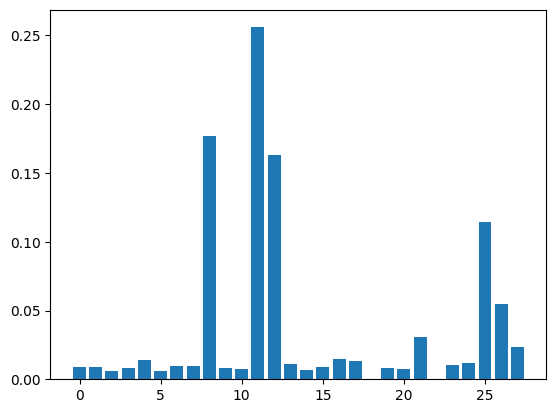

In [ ]:
plt.bar(range(len(XGB.feature_importances_)), XGB.feature_importances_)
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

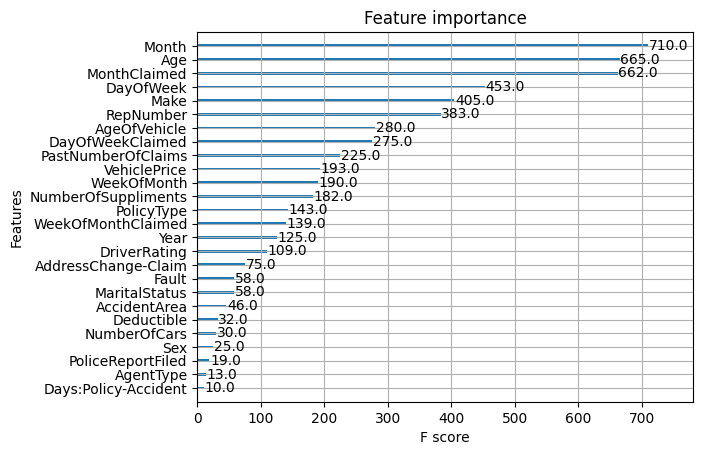

In [ ]:
from xgboost import plot_importance
plot_importance(XGB)

### Logistic Regression

In [ ]:
#Create X, y
y_onehot = df_onehot[['FraudFound']]
X_onehot = df_onehot.drop('FraudFound', axis=1)
y_onehot['FraudFound'].apply(lambda x: 0 if x=="No" else 1)
y_onehot = y_onehot.values

In [ ]:
#train,test split
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_onehot, y_onehot, random_state = 99, stratify= y_onehot)

In [ ]:
type(y_train_lr)

numpy.ndarray

In [ ]:
from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler()

In [ ]:
scaler_x = Scaler.fit(X_train_lr)

In [ ]:
X_train_scaler = scaler_x.transform(X_train_lr)

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=5000, C=0.001)

In [ ]:

y_train_lr.shape

(11565, 1)

In [ ]:
lr.fit(X_train_lr, y_train_lr.ravel())

LogisticRegression(C=0.001, max_iter=5000)

In [ ]:
X_test_scaler = scaler_x.transform(X_test_lr)

In [ ]:
y_pred = lr.predict(X_test_scaler)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [ ]:
y_pred.shape

(3855,)

In [ ]:
X_test_lr.shape

(3855, 132)

In [ ]:
y_test_lr.shape

(3855, 1)

              precision    recall  f1-score   support

           0       0.99      0.56      0.71      3624
           1       0.11      0.89      0.20       231

    accuracy                           0.58      3855
   macro avg       0.55      0.72      0.46      3855
weighted avg       0.94      0.58      0.68      3855



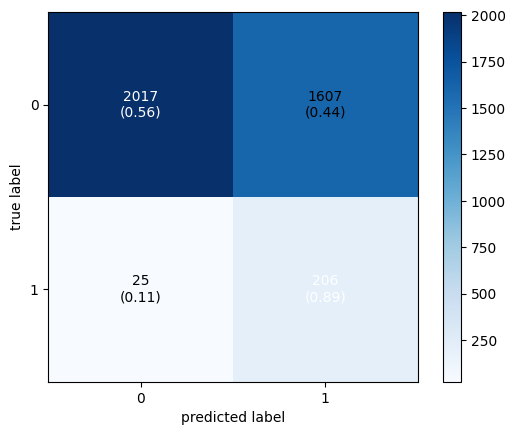

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
print(classification_report(y_test_lr, y_pred))
cm1 = confusion_matrix(y_test_lr,y_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

In [ ]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7)}# l1 lasso l2 ridge
logreg=LogisticRegression(max_iter=5000)
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train_lr, y_train_lr.ravel())

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.001}
accuracy : 0.9401643523849115


#### Undersample

In [ ]:
ros = RandomUnderSampler(random_state=99)
X_undersam_lr, y_undersam_lr = ros.fit_resample(X_train_lr, y_train_lr)

In [ ]:
lr.fit(X_undersam_lr, y_undersam_lr.ravel())

LogisticRegression(C=0.001, max_iter=5000)

In [ ]:
y_pred_ly_under = lr.predict(X_test_scaler)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      0.55      0.71      3624
           1       0.11      0.88      0.20       231

    accuracy                           0.57      3855
   macro avg       0.55      0.72      0.45      3855
weighted avg       0.93      0.57      0.68      3855



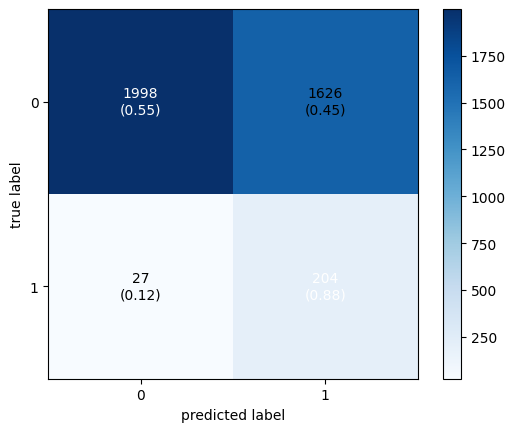

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
print(classification_report(y_test_lr, y_pred_ly_under))
cm1 = confusion_matrix(y_test_lr,y_pred_ly_under)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

#### Oversampling

In [ ]:
ros = RandomOverSampler(random_state=99)
X_oversam_lr, y_oversam_lr = ros.fit_resample(X_train_lr, y_train_lr)

In [ ]:
lr.fit(X_oversam_lr, y_oversam_lr.ravel())

LogisticRegression(C=0.001, max_iter=5000)

In [ ]:
y_pred_ly_over = lr.predict(X_test_scaler)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      0.56      0.72      3624
           1       0.12      0.94      0.21       231

    accuracy                           0.59      3855
   macro avg       0.56      0.75      0.47      3855
weighted avg       0.94      0.59      0.69      3855



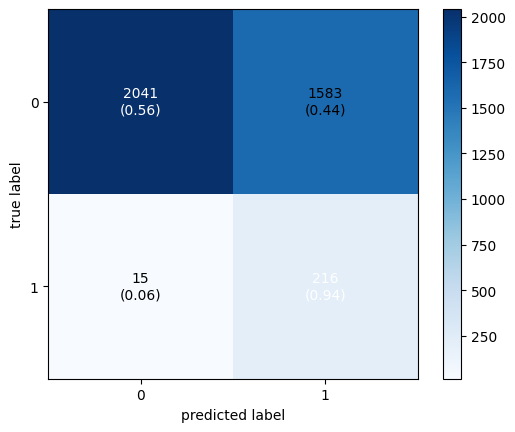

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
print(classification_report(y_test_lr, y_pred_ly_over))
cm1 = confusion_matrix(y_test_lr,y_pred_ly_over)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

#### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE(sampling_strategy='minority',random_state=99,k_neighbors=5)

In [ ]:
X_smote_lr, y_smote_lr = smote.fit_resample(X_train_lr, y_train_lr)

In [ ]:
lr.fit(X_smote_lr, y_smote_lr.ravel())

LogisticRegression(C=0.001, max_iter=5000)

In [ ]:
y_pred_lr_smote = lr.predict(X_test_scaler)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      0.54      0.70      3624
           1       0.11      0.91      0.20       231

    accuracy                           0.56      3855
   macro avg       0.55      0.72      0.45      3855
weighted avg       0.94      0.56      0.67      3855



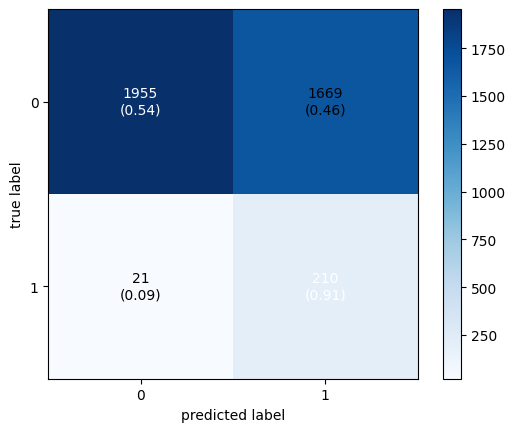

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
print(classification_report(y_test_lr, y_pred_lr_smote))
cm1 = confusion_matrix(y_test_lr,y_pred_lr_smote)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

### KNN

In [ ]:
y_onehot = df_onehot[['FraudFound']]
X_onehot = df_onehot.drop('FraudFound', axis=1)
y_onehot['FraudFound'].apply(lambda x: 0 if x=="No" else 1)
y_onehot = y_onehot.values.ravel()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y_onehot, random_state=99, stratify=y_onehot)

In [ ]:
from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler()

In [ ]:
x_scale = Scaler.fit(X_train)

In [ ]:
X_scaled = x_scale.transform(X_train)

In [ ]:
neighbours = np.arange(1,25)
train_accuracy =np.empty(len(neighbours))
test_accuracy = np.empty(len(neighbours))

for i,k in enumerate(neighbours):
    #Setup a knn classifier with k neighbors
    knn=KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",n_jobs=-1)
    
    #Fit the model
    knn.fit(X_scaled,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_scaled, y_train)
    x_test_scaled = x_scale.transform(X_test)
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(x_test_scaled, y_test) 

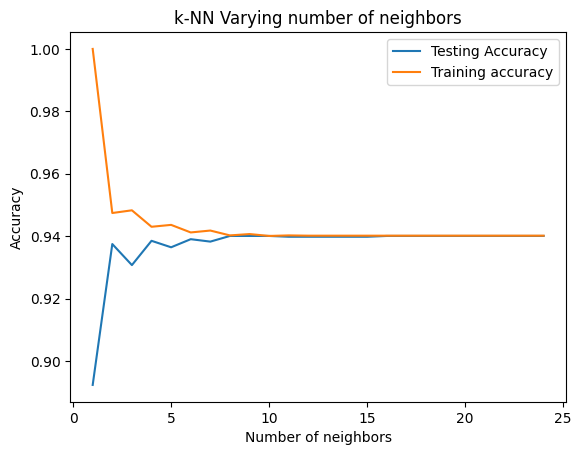

In [ ]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbours, test_accuracy, label='Testing Accuracy')
plt.plot(neighbours, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
idx = np.where(test_accuracy == max(test_accuracy))
x = neighbours[idx]

In [ ]:
x

array([ 8,  9, 10, 16, 17, 18, 19, 20, 21, 22, 23, 24])

In [ ]:
knn=KNeighborsClassifier(n_neighbors=8)
knn.fit(X_scaled,y_train)

KNeighborsClassifier(n_neighbors=8)

In [ ]:
x_test_scaled = x_scale.transform(X_test)

In [ ]:
y_pred_knn = knn.predict(x_test_scaled)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3624
           1       0.50      0.00      0.01       231

    accuracy                           0.94      3855
   macro avg       0.72      0.50      0.49      3855
weighted avg       0.91      0.94      0.91      3855



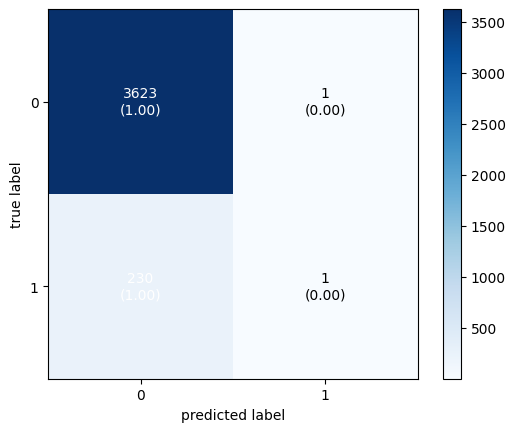

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
print(classification_report(y_test, y_pred_knn))
cm1 = confusion_matrix(y_test,y_pred_knn)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

#### Undersampling

In [ ]:
ros = RandomUnderSampler(random_state=99)
X_undersam_knn, y_undersam_knn = ros.fit_resample(X_scaled, y_train)

In [ ]:
knn.fit(X_undersam_knn, y_undersam_knn)

KNeighborsClassifier(n_neighbors=8)

In [ ]:
y_under_knn = knn.predict(x_test_scaled)

              precision    recall  f1-score   support

           0       0.96      0.71      0.81      3624
           1       0.11      0.55      0.18       231

    accuracy                           0.70      3855
   macro avg       0.53      0.63      0.50      3855
weighted avg       0.91      0.70      0.78      3855



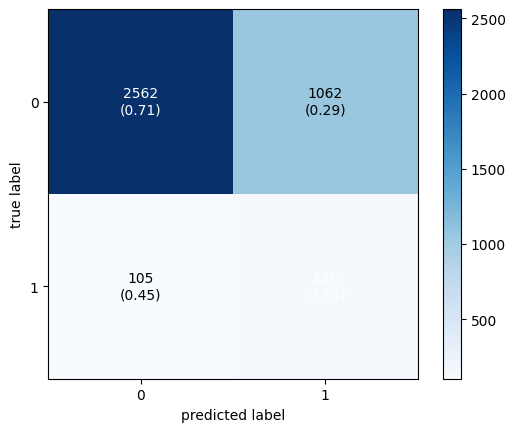

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
print(classification_report(y_test, y_under_knn))
cm1 = confusion_matrix(y_test,y_under_knn)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

#### Oversampling

In [ ]:
ros = RandomOverSampler(random_state=99)
X_oversam_knn, y_oversam_knn = ros.fit_resample(X_scaled, y_train)
knn.fit(X_oversam_knn, y_oversam_knn.ravel())

KNeighborsClassifier(n_neighbors=8)

In [ ]:
y_over_knn = knn.predict(x_test_scaled)

              precision    recall  f1-score   support

           0       0.95      0.81      0.87      3624
           1       0.10      0.32      0.15       231

    accuracy                           0.78      3855
   macro avg       0.52      0.57      0.51      3855
weighted avg       0.90      0.78      0.83      3855



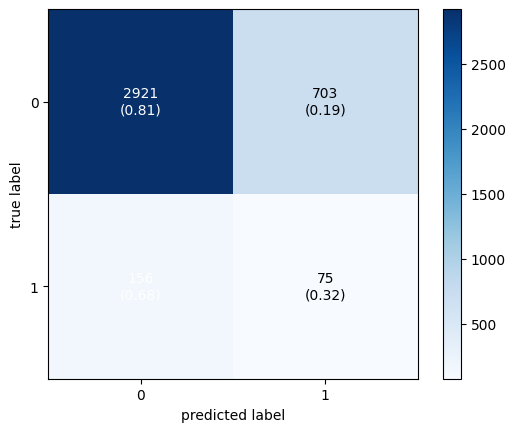

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
print(classification_report(y_test, y_over_knn))
cm1 = confusion_matrix(y_test,y_over_knn)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

#### SMOTE

In [ ]:
smote = SMOTE(sampling_strategy='minority',random_state=99,k_neighbors=5)
X_smote_knn, y_smote_knn = smote.fit_resample(X_scaled, y_train)
knn.fit(X_smote_knn, y_smote_knn)

KNeighborsClassifier(n_neighbors=8)

In [ ]:
y_smote_knn = knn.predict(x_test_scaled)

              precision    recall  f1-score   support

           0       0.96      0.63      0.76      3624
           1       0.10      0.62      0.17       231

    accuracy                           0.63      3855
   macro avg       0.53      0.62      0.46      3855
weighted avg       0.91      0.63      0.72      3855



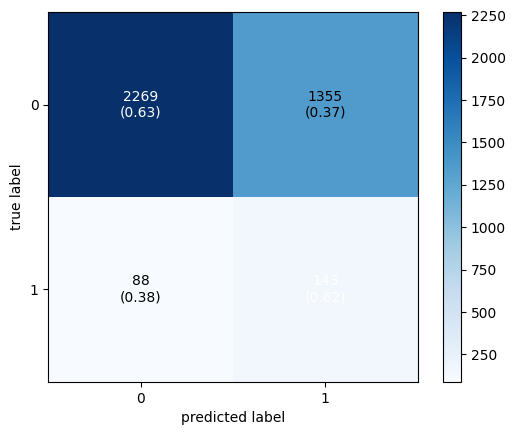

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
print(classification_report(y_test, y_smote_knn))
cm1 = confusion_matrix(y_test,y_smote_knn)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

#PCA
หลังจากนั้นจะนำ model จาก Section ก่อนหน้าแต่ครั้งนี้จะเพิ่มการลดมิติข้อมูล

ด้วยวิธี Principle COmponent Analysis เข้าไปด้วยโดยกำหนด n_component ไว้ที่ 0.95

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y_onehot, test_size=0.2, random_state=99, stratify=y)

In [ ]:
x_test_scaled = x_scale.transform(X_test)

In [ ]:
x_test_scaled #X_test with StandardScaler

array([[-0.61800482,  1.8251897 , -0.06503334, ..., -0.15548765,
        -0.03836817, -0.01315163],
       [ 0.93371593,  1.03289487, -0.43684991, ..., -0.15548765,
        -0.03836817, -0.01315163],
       [ 0.93371593,  1.03289487,  0.75296312, ..., -0.15548765,
        -0.03836817, -0.01315163],
       ...,
       [ 0.15785555,  0.24060004, -0.51121322, ..., -0.15548765,
        -0.03836817, -0.01315163],
       [ 0.15785555,  0.24060004, -0.65993985, ..., -0.15548765,
        -0.03836817, -0.01315163],
       [-0.61800482,  0.24060004, -0.36248659, ..., -0.15548765,
        -0.03836817, -0.01315163]])

In [ ]:
X_scaled = x_scale.transform(X_train) #X_train with StandardScaler

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
pca.fit(X_scaled)

PCA(n_components=2)

In [ ]:
x_pca = pca.transform(X_scaled)

In [ ]:
X_scaled.shape #X_train with StandardScaler

(12336, 132)

In [ ]:
x_pca.shape #X_train with StandardScaler with PCA

(12336, 2)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns

In [ ]:
X_train.shape

(12336, 132)

In [ ]:
y_train.shape

(12336,)

<Axes: >

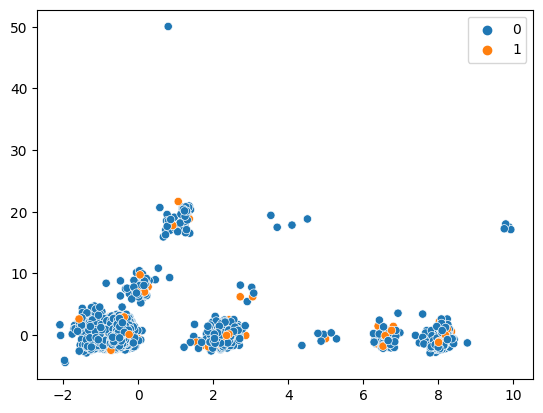

In [ ]:
sns.scatterplot(x=x_pca[:,0],y=x_pca[:,1], hue=y_train)

## PCA With LogisticRegression

### Pipeline


1.   SMOTE
2.   StandardScaler
3.   PCA
4.   LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, cross_validate
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from imblearn.over_sampling import RandomOverSampler

In [ ]:
pipe = Pipeline(steps=[('smote', SMOTE(random_state=99)),
                       ('standardscaler', StandardScaler()),
                       ('pca', PCA(0.95)),
                       ('logisticregression', LogisticRegression(max_iter=5000))])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=99)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('logisticregression', LogisticRegression(max_iter=5000))])

In [ ]:
cross_validate(pipe, X_train, y_train)

{'fit_time': array([0.76432657, 0.62954283, 0.76303506, 0.78394008, 0.76455569]),
 'score_time': array([0.01005816, 0.01033211, 0.01095057, 0.01039362, 0.00985789]),
 'test_score': array([0.93922204, 0.93960276, 0.937576  , 0.94000811, 0.94000811])}

In [ ]:
pred_pipe = pipe.predict(X_test)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2899
           1       0.38      0.02      0.03       185

    accuracy                           0.94      3084
   macro avg       0.66      0.51      0.50      3084
weighted avg       0.91      0.94      0.91      3084



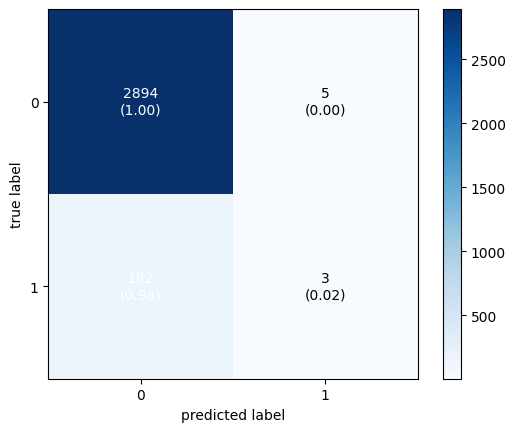

In [ ]:
print(classification_report(y_test, pred_pipe))
cm1 = confusion_matrix(y_test,pred_pipe)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

### Pipeline


1.   Undersampling
2.   StandardScaler
3.   PCA
4.   LogisticRegression





In [ ]:
pipe = Pipeline(steps=[('ros', RandomUnderSampler(random_state=99)),
                       ('standardscaler', StandardScaler()),
                       ('pca', PCA(0.95)),
                       ('logisticregression', LogisticRegression(max_iter=5000))])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('ros', RandomUnderSampler(random_state=99)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('logisticregression', LogisticRegression(max_iter=5000))])

In [ ]:
cross_validate(pipe, X_train, y_train)

{'fit_time': array([0.10474825, 0.11958432, 0.15028954, 0.13826132, 0.08189654]),
 'score_time': array([0.01031637, 0.01017618, 0.01737309, 0.01073599, 0.00884461]),
 'test_score': array([0.64465154, 0.64491285, 0.64856101, 0.65504662, 0.65058776])}

In [ ]:
pred_pipe = pipe.predict(X_test)

              precision    recall  f1-score   support

           0       0.98      0.65      0.78      2899
           1       0.13      0.83      0.23       185

    accuracy                           0.66      3084
   macro avg       0.56      0.74      0.50      3084
weighted avg       0.93      0.66      0.75      3084



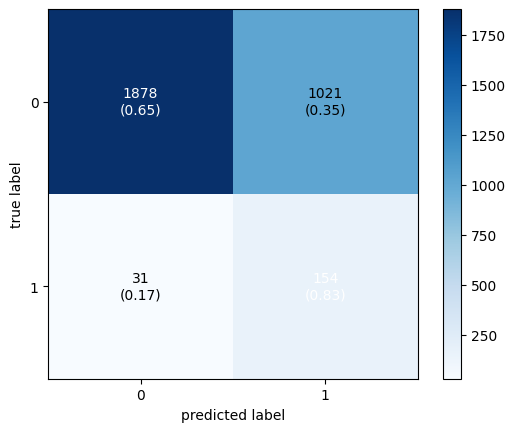

In [ ]:
print(classification_report(y_test, pred_pipe))
cm1 = confusion_matrix(y_test,pred_pipe)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

### Pipeline


1.   Oversampling
2.   StandardScaler
3.   PCA
4.   LogisticRegression

In [ ]:
pipe = Pipeline(steps=[('ros', RandomOverSampler(random_state=99)),
                       ('standardscaler', StandardScaler()),
                       ('pca', PCA(0.95)),
                       ('logisticregression', LogisticRegression(max_iter=5000))])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('ros', RandomOverSampler(random_state=99)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('logisticregression', LogisticRegression(max_iter=5000))])

In [ ]:
cross_validate(pipe, X_train, y_train)

{'fit_time': array([1.17528629, 0.62736607, 0.7844789 , 0.90776992, 0.83108425]),
 'score_time': array([0.01005077, 0.01278973, 0.02120042, 0.01117969, 0.0099721 ]),
 'test_score': array([0.65559157, 0.65666802, 0.66072152, 0.64856101, 0.6477503 ])}

In [ ]:
pred_pipe = pipe.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      0.64      0.77      2899
           1       0.13      0.89      0.23       185

    accuracy                           0.65      3084
   macro avg       0.56      0.76      0.50      3084
weighted avg       0.94      0.65      0.74      3084



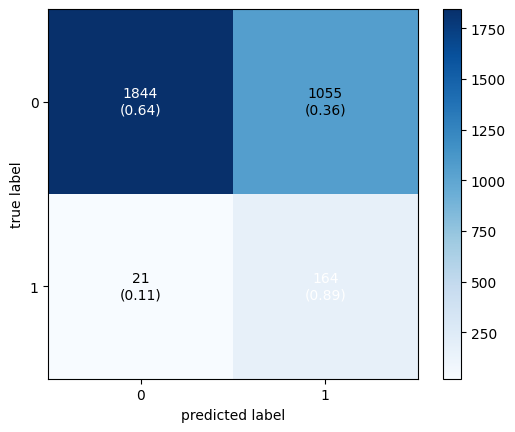

In [ ]:
print(classification_report(y_test, pred_pipe))
cm1 = confusion_matrix(y_test,pred_pipe)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

## PCA With KNN

### Pipeline


1.   Smote
2.   StandardScaler
3.   PCA
4.   KNN

In [ ]:
pipe = Pipeline(steps=[('smote', SMOTE(random_state=99)),
                       ('standardscaler', StandardScaler()),
                       ('pca', PCA(0.95)),
                       ('knn', KNeighborsClassifier(n_neighbors=8))])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=99)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('knn', KNeighborsClassifier(n_neighbors=8))])

In [ ]:
cross_validate(pipe, X_train, y_train)

{'fit_time': array([0.396106  , 0.38033009, 0.3746047 , 0.39048862, 0.38713336]),
 'score_time': array([0.4903605 , 0.48206782, 0.48427057, 0.51766372, 0.56636262]),
 'test_score': array([0.74432739, 0.7389542 , 0.73044183, 0.7438184 , 0.72841508])}

In [ ]:
pred_pipe = pipe.predict(X_test)

              precision    recall  f1-score   support

           0       0.95      0.76      0.85      2899
           1       0.10      0.40      0.16       185

    accuracy                           0.74      3084
   macro avg       0.52      0.58      0.50      3084
weighted avg       0.90      0.74      0.81      3084



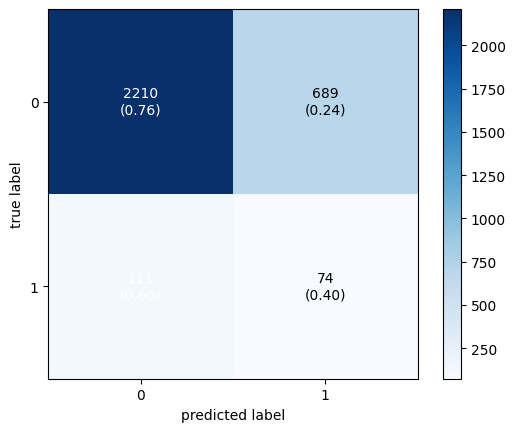

In [ ]:
print(classification_report(y_test, pred_pipe))
cm1 = confusion_matrix(y_test,pred_pipe)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

### Pipeline


1.   Undersampling
2.   StandardScaler
3.   PCA
4.   KNN

In [ ]:
pipe = Pipeline(steps=[('ros', RandomUnderSampler(random_state=99)),
                       ('standardscaler', StandardScaler()),
                       ('pca', PCA(0.95)),
                       ('knn', KNeighborsClassifier(n_neighbors=8))])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('ros', RandomUnderSampler(random_state=99)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('knn', KNeighborsClassifier(n_neighbors=8))])

In [ ]:
cross_validate(pipe, X_train, y_train)

{'fit_time': array([0.13880587, 0.08083248, 0.09713793, 0.08958769, 0.0943644 ]),
 'score_time': array([0.21678948, 0.20089459, 0.24102497, 0.2675488 , 0.20860434]),
 'test_score': array([0.69205835, 0.69314957, 0.67531415, 0.68990677, 0.69679773])}

In [ ]:
pred_pipe = pipe.predict(X_test)

              precision    recall  f1-score   support

           0       0.96      0.69      0.81      2899
           1       0.11      0.61      0.19       185

    accuracy                           0.69      3084
   macro avg       0.54      0.65      0.50      3084
weighted avg       0.91      0.69      0.77      3084



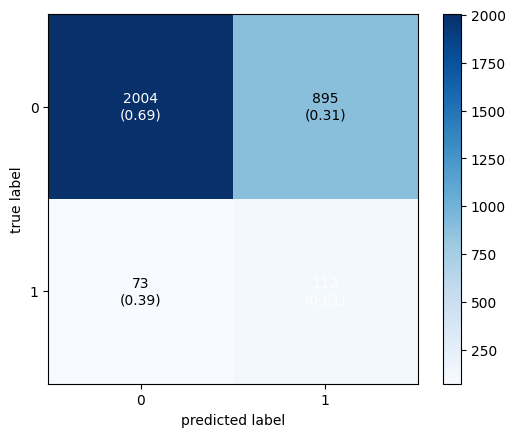

In [ ]:
print(classification_report(y_test, pred_pipe))
cm1 = confusion_matrix(y_test,pred_pipe)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

### Pipeline


1.   Oversampling
2.   StandardScaler
3.   PCA
4.   KNN

In [ ]:
pipe = Pipeline(steps=[('ros', RandomOverSampler(random_state=99)),
                       ('standardscaler', StandardScaler()),
                       ('pca', PCA(0.95)),
                       ('knn', KNeighborsClassifier(n_neighbors=8))])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('ros', RandomOverSampler(random_state=99)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('knn', KNeighborsClassifier(n_neighbors=8))])

In [ ]:
cross_validate(pipe, X_train, y_train)

{'fit_time': array([0.37258053, 0.35329318, 0.32734847, 0.35541868, 0.33664775]),
 'score_time': array([0.48042846, 0.47453761, 0.4890008 , 0.47719574, 0.474751  ]),
 'test_score': array([0.77269044, 0.79691934, 0.78070531, 0.78759627, 0.78719092])}

In [ ]:
pred_pipe = pipe.predict(X_test)

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      2899
           1       0.10      0.32      0.15       185

    accuracy                           0.79      3084
   macro avg       0.53      0.57      0.52      3084
weighted avg       0.90      0.79      0.83      3084



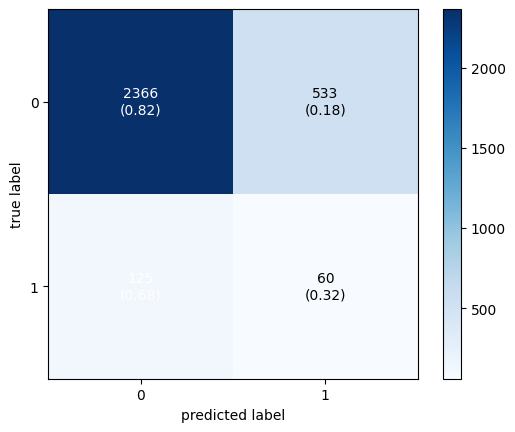

In [ ]:
print(classification_report(y_test, pred_pipe))
cm1 = confusion_matrix(y_test,pred_pipe)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

## PCA with XGBoost

### Pipeline


1.   Oversampling
2.   StandardScaler
3.   PCA
4.   XGBoost

In [ ]:
from xgboost import XGBClassifier
# XGB = xgb.XGBClassifier(eta=0.1, gamma=1, max_depth=5, enable_categorical=True,
#                        tree_method='gpu_hist', n_estimators=1000,
#                        reg_alpha=0.005)

In [ ]:
pipe = Pipeline(steps=[('ros', RandomOverSampler(random_state=99)),
                       ('standardscaler', StandardScaler()),
                       ('pca', PCA(0.95)),
                       ('xgb', XGBClassifier(eta=0.1, gamma=1, max_depth=5, enable_categorical=True,
                          tree_method='gpu_hist', n_estimators=1000,
                          reg_alpha=0.005))])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('ros', RandomOverSampler(random_state=99)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eta=0.1,
                               eval_metric=None, feature_types=None, gamma=1,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=1000,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, ...))])

In [ ]:
cross_validate(pipe, X_train, y_train)

{'fit_time': array([1.88929105, 2.56748557, 1.89234447, 1.87871122, 1.87509084]),
 'score_time': array([0.0458827 , 0.03459001, 0.03729963, 0.05649829, 0.04204965]),
 'test_score': array([0.92747164, 0.93311715, 0.93149574, 0.92703689, 0.93068504])}

In [ ]:
pred_pipe = pipe.predict(X_test)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2899
           1       0.17      0.06      0.09       185

    accuracy                           0.93      3084
   macro avg       0.56      0.52      0.53      3084
weighted avg       0.90      0.93      0.91      3084



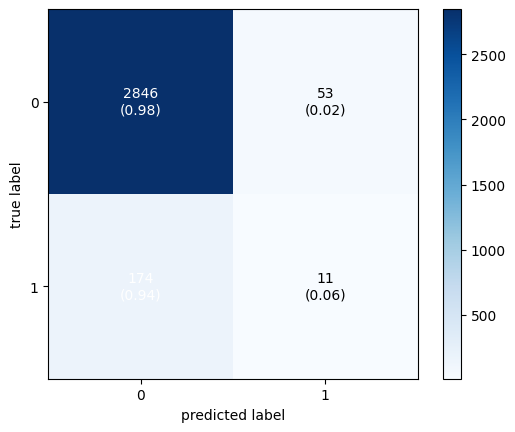

In [ ]:
print(classification_report(y_test, pred_pipe))
cm1 = confusion_matrix(y_test,pred_pipe)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

### Pipeline


1.   Undersampling
2.   StandardScaler
3.   PCA
4.   XGBoost

In [ ]:
pipe = Pipeline(steps=[('ros', RandomUnderSampler(random_state=99)),
                       ('standardscaler', StandardScaler()),
                       ('pca', PCA(0.95)),
                       ('xgb', XGBClassifier(eta=0.1, gamma=1, max_depth=5, enable_categorical=True,
                          tree_method='gpu_hist', n_estimators=1000,
                          reg_alpha=0.005))])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('ros', RandomUnderSampler(random_state=99)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eta=0.1,
                               eval_metric=None, feature_types=None, gamma=1,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=1000,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, ...))])

In [ ]:
cross_validate(pipe, X_train, y_train)

{'fit_time': array([0.77452302, 0.74405003, 0.73609686, 0.84752345, 0.99253464]),
 'score_time': array([0.01871443, 0.02227712, 0.02941871, 0.04483461, 0.0359714 ]),
 'test_score': array([0.65964344, 0.65018241, 0.66599108, 0.68179976, 0.67044994])}

In [ ]:
pred_pipe = pipe.predict(X_test)

              precision    recall  f1-score   support

           0       0.98      0.65      0.78      2899
           1       0.12      0.77      0.21       185

    accuracy                           0.66      3084
   macro avg       0.55      0.71      0.50      3084
weighted avg       0.93      0.66      0.75      3084



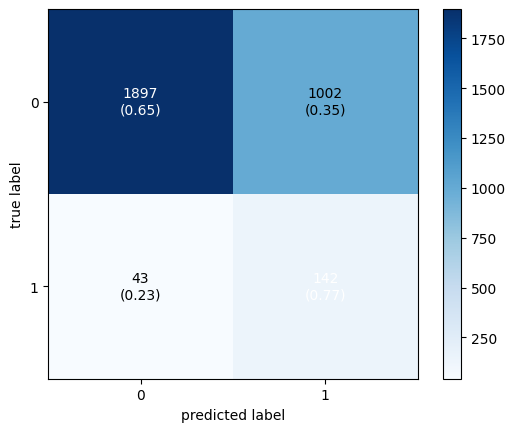

In [ ]:
print(classification_report(y_test, pred_pipe))
cm1 = confusion_matrix(y_test,pred_pipe)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

### Pipeline


1.   SMOTE
2.   StandardScaler
3.   PCA
4.   XGBoost

In [ ]:
pipe = Pipeline(steps=[('SMOTE', SMOTE(random_state=99)),
                       ('standardscaler', StandardScaler()),
                       ('pca', PCA(0.95)),
                       ('xgb', XGBClassifier(eta=0.1, gamma=1, max_depth=5, enable_categorical=True,
                          tree_method='gpu_hist', n_estimators=1000,
                          reg_alpha=0.005))])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('SMOTE', SMOTE(random_state=99)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eta=0.1,
                               eval_metric=None, feature_types=None, gamma=1,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=1000,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, ...))])

In [ ]:
cross_validate(pipe,X_train, y_train)

{'fit_time': array([1.71572137, 1.74863148, 1.72222424, 1.69998956, 1.77705288]),
 'score_time': array([0.03227496, 0.02619433, 0.02677703, 0.02969432, 0.05096316]),
 'test_score': array([0.93476499, 0.93635995, 0.93919741, 0.93473855, 0.93554925])}

In [ ]:
pred_pipe = pipe.predict(X_test)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2899
           1       0.43      0.05      0.09       185

    accuracy                           0.94      3084
   macro avg       0.69      0.52      0.53      3084
weighted avg       0.91      0.94      0.92      3084



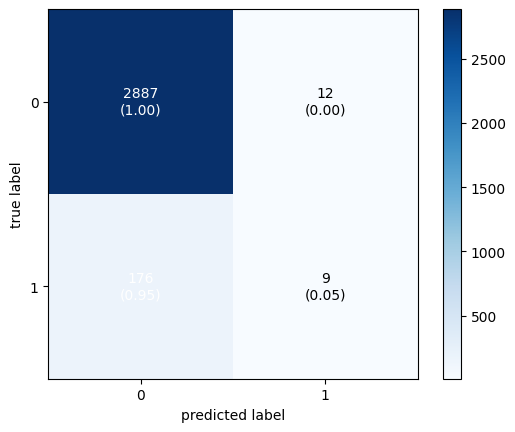

In [ ]:
print(classification_report(y_test, pred_pipe))
cm1 = confusion_matrix(y_test,pred_pipe)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

# Features Selection

ต่อไปเราจะมาลองเปรี่ยบเทียบระหว่าง


1.   ใช้ข้อมูลทุก Features
2.   Feture Selection
3.   PCA

โดยเราจะใช่้ Model ที่น่าสนใจจาก Section ก่อนหน้ามาทดลองคือ 


*   Logistic Regression With Undersampling
*   XGBoost with UnderSampling





## XGBoost with UnderSampling

### Full Features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y_onehot, test_size=0.2, random_state=99, stratify=y)

In [ ]:
pipe = Pipeline(steps=[('rus', RandomUnderSampler(random_state=99)),
                       ('standardscaler', StandardScaler()),
                       ('xgb', XGBClassifier(eta=0.1, gamma=3, max_depth=10, enable_categorical=True,
                          tree_method='gpu_hist', n_estimators=1000,
                          reg_alpha=0.005, validate_parameters=True))])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('rus', RandomUnderSampler(random_state=99)),
                ('standardscaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eta=0.1,
                               eval_metric=None, feature_types=None, gamma=3,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=1000,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, ...))])

In [ ]:
cross_validate(pipe, X_train, y_train)

{'fit_time': array([0.68416882, 0.57358384, 0.59526801, 0.58830214, 0.57661748]),
 'score_time': array([0.01338267, 0.01417089, 0.01507831, 0.01582789, 0.01502419]),
 'test_score': array([0.62601297, 0.60032428, 0.62505067, 0.61045805, 0.61775436])}

In [ ]:
pred_pipe = pipe.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      0.61      0.76      2899
           1       0.13      0.94      0.23       185

    accuracy                           0.63      3084
   macro avg       0.56      0.77      0.49      3084
weighted avg       0.94      0.63      0.72      3084



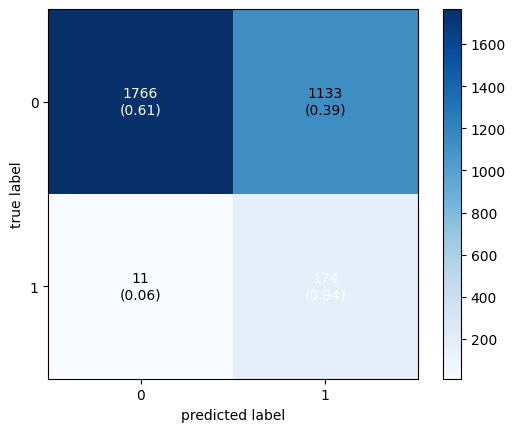

In [ ]:
print(classification_report(y_test, pred_pipe))
cm1 = confusion_matrix(y_test,pred_pipe)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

### PCA 80%

In [ ]:
pipe = Pipeline(steps=[('rus', RandomUnderSampler(random_state=99)),
                       ('standardscaler', StandardScaler()),
                       ('pca', PCA(0.8)),
                       ('xgb', XGBClassifier(eta=0.1, gamma=3, max_depth=10, enable_categorical=True,
                          tree_method='gpu_hist', n_estimators=1000,
                          reg_alpha=0.005, validate_parameters=True))])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('rus', RandomUnderSampler(random_state=99)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.8)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eta=0.1,
                               eval_metric=None, feature_types=None, gamma=3,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=1000,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, ...))])

In [ ]:
cross_validate(pipe, X_train, y_train)

{'fit_time': array([0.96822238, 1.00381374, 0.91212773, 0.99406099, 0.91566467]),
 'score_time': array([0.03531027, 0.01796198, 0.02030969, 0.02323508, 0.02044201]),
 'test_score': array([0.64951378, 0.62018646, 0.65423591, 0.6420754 , 0.6453182 ])}

In [ ]:
pred_pipe = pipe.predict(X_test)

              precision    recall  f1-score   support

           0       0.97      0.63      0.77      2899
           1       0.11      0.74      0.20       185

    accuracy                           0.64      3084
   macro avg       0.54      0.69      0.48      3084
weighted avg       0.92      0.64      0.73      3084



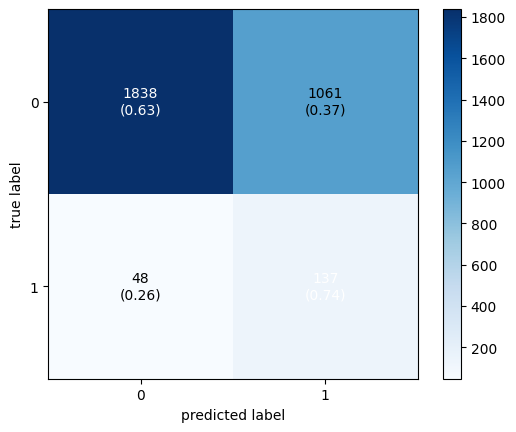

In [ ]:
print(classification_report(y_test, pred_pipe))
cm1 = confusion_matrix(y_test,pred_pipe)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

### Fetures Selection

#### Features Importance

In [ ]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  int64 
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  int64 
 3   Make                  15420 non-null  int64 
 4   AccidentArea          15420 non-null  int64 
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  int64 
 9   MaritalStatus         15420 non-null  int64 
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  int64 
 12  PolicyType            15420 non-null  int64 
 13  VehiclePrice          15420 non-null  int64 
 14  RepNumber             15420 non-null  int64 
 15  Deductible            15420 non-null

In [ ]:
df_drop['DayOfWeekClaimed'] = df_drop['DayOfWeekClaimed'].astype("int64")

In [ ]:
df_drop['MonthClaimed'] = df_drop['MonthClaimed'].astype("int64")

In [ ]:
y = df_drop['FraudFound'].values
X = df_drop.drop(['FraudFound'], axis=1)

In [ ]:
#ลอง Train model ด้วย Full Features อีกครั้งเพื่อเปรียบเทียบ
import xgboost as xgb
XGB = xgb.XGBClassifier(eta=0.1, gamma=1, max_depth=5, enable_categorical=True,
                       tree_method='gpu_hist', n_estimators=1000,
                       reg_alpha=0.005)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, stratify=y)

In [ ]:
ros = RandomUnderSampler(random_state=99)
X_under_train, y_under_train = ros.fit_resample(X_train, y_train)

In [ ]:
XGB.fit(X_under_train, y_under_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.1, eval_metric=None,
              feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
cross_validate(XGB, X_under_train, y_under_train)

{'fit_time': array([0.83886003, 1.05879331, 0.66950417, 0.66321135, 0.69293022]),
 'score_time': array([0.02789783, 0.00432968, 0.00448132, 0.00452709, 0.00408149]),
 'test_score': array([0.79422383, 0.76895307, 0.73646209, 0.7833935 , 0.79710145])}

In [ ]:
pred = XGB.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      0.63      0.77      3624
           1       0.14      0.93      0.24       231

    accuracy                           0.64      3855
   macro avg       0.56      0.78      0.50      3855
weighted avg       0.94      0.64      0.74      3855



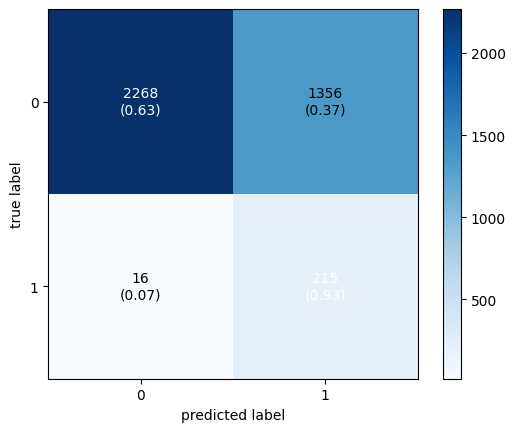

In [ ]:
print(classification_report(y_test, pred))
cm1 = confusion_matrix(y_test,pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

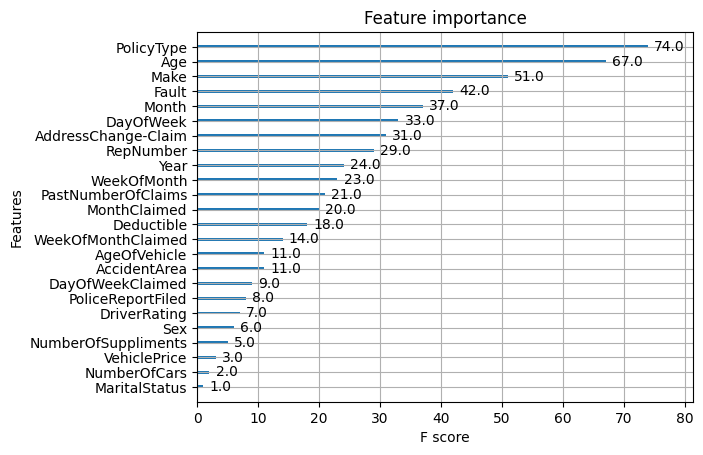

In [ ]:
#ทำการ Plot หา Features Importance ของ Model XGBoost ที่ได้ train 
xgb.plot_importance(XGB)

In [ ]:
#ทดลองเลือก Features มา 7 features ที่มีค่า F score สูงที่สุดเพื่อ Train Model
X_under_selected = X_under_train[['PolicyType','Age','Make','Fault','Month','AddressChange-Claim',
                                  'RepNumber']]

In [ ]:
XGB.fit(X_under_selected, y_under_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.1, eval_metric=None,
              feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
cross_validate(XGB, X_under_selected, y_under_train)

{'fit_time': array([0.58038878, 0.59534407, 0.56037974, 0.55838418, 0.5544126 ]),
 'score_time': array([0.0037601 , 0.00380421, 0.00351262, 0.00353503, 0.00349569]),
 'test_score': array([0.80144404, 0.7400722 , 0.75090253, 0.77256318, 0.77536232])}

In [ ]:
X_selected_test = X_test[['PolicyType','Age','Make','Fault','Month','AddressChange-Claim',
                                  'RepNumber']]

In [ ]:
pred = XGB.predict(X_selected_test)

              precision    recall  f1-score   support

           0       0.99      0.59      0.74      3624
           1       0.13      0.94      0.22       231

    accuracy                           0.61      3855
   macro avg       0.56      0.76      0.48      3855
weighted avg       0.94      0.61      0.71      3855



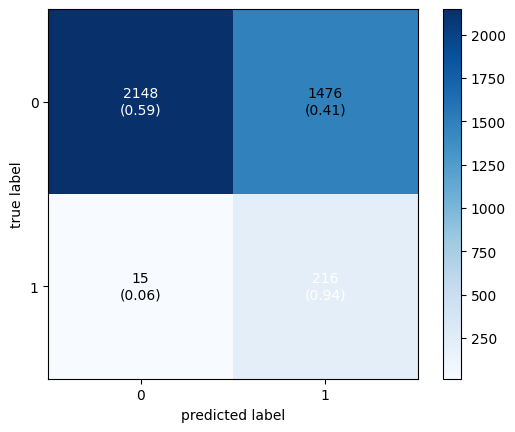

In [ ]:
print(classification_report(y_test, pred))
cm1 = confusion_matrix(y_test,pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 11.3 MB/s eta 0:00:00


In [ ]:
import shap
explainer = shap.TreeExplainer(XGB)
shap_values = explainer.shap_values(X_under_selected)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
shap.initjs()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


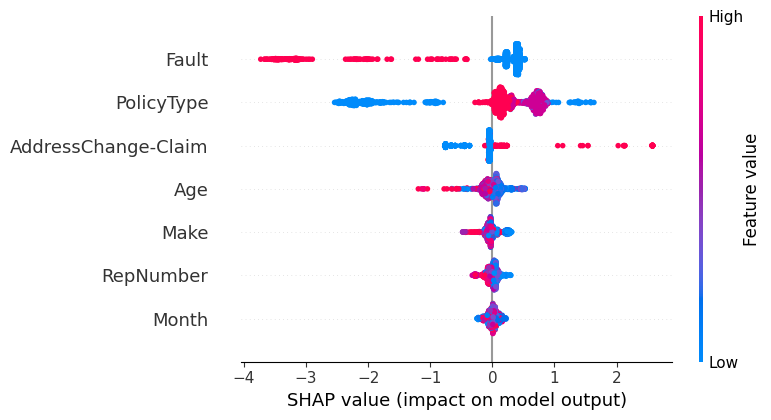

In [ ]:
#ใช้ Shap เพื่อ Plot ดูว่า Feature ที่เราเลือกมามี Impact ต่อ Model Output ขนาดไหน
shap.summary_plot(shap_values, X_under_selected)

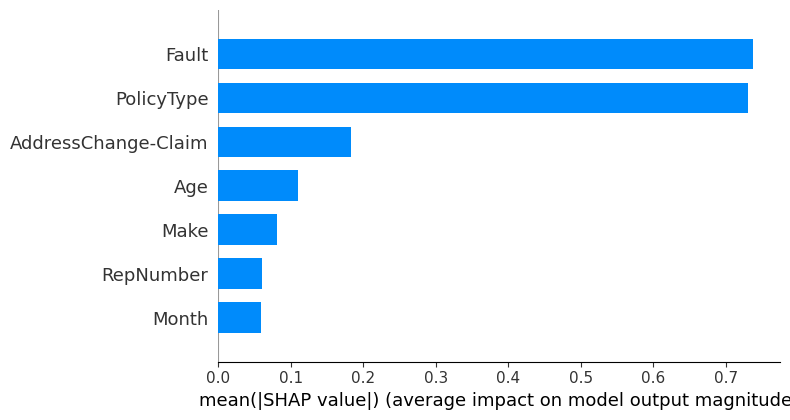

In [ ]:
shap.summary_plot(shap_values, X_under_selected, plot_type="bar")

In [ ]:
###**Conclusion**###
'''
โดยสรุปเมื่อลองทำ Features Selection โดยการ Plot หา Fetures Importance และทำการลด Feature ที่ใช้เทรน Model XGBoost เหลือเพียง 7 Features 
จากทั้งหมด 33 Features ได้แก่ 'PolicyType', 'Age', 'Make', 'Fault', 'Month','AddressChange-Claim', 'RepNumber'
'''

###**Model**###
'''
ให้ค่า Accuracy ลดลงจากเดิมเล็กน้อยจาก 0.64 เป็น 0.61
อย่างไรก็ตามค่า Precision ต่อ class 0 ยังคงที่ที่ 0.99
และค่า Recall ต่อ class 1 ยังคงที่ที่ 0.94
แต่หากลด Features ไปมากกว่านี้จะทำให้ค่าลดลงอย่างชัดเจน 
ดังนั่นจำนวน Features อยที่สุดที่สามารถคงระดีบความแม่นยำเอาไว้ใกล้เคียงเดิม
คือ 7 Features
'''

'\nให้ค่า Accuracy ลดลงจากเดิมเล็กน้อยจาก 0.64 เป็น 0.61\nอย่างไรก็ตามค่า Precision ต่อ class 0 ยังคงที่ที่ 0.99\nและค่า Recall ต่อ class 1 ยังคงที่ที่ 0.94\nแต่หากลด Features ไปมากกว่านี้จะทำให้ค่าลดลงอย่างชัดเจน \nดังนั่นจำนวน Features อยที่สุดที่สามารถคงระดีบความแม่นยำเอาไว้ใกล้เคียงเดิม\nคือ 7 Features\n'

#### Permutation Impotance

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
XGB1 = xgb.XGBClassifier(eta=0.1, gamma=1, max_depth=5, enable_categorical=True,
                       tree_method='gpu_hist', n_estimators=1000,
                       reg_alpha=0.005)

In [ ]:
XGB1.fit(X_under_train, y_under_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.1, eval_metric=None,
              feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:

r = permutation_importance(XGB1, X_under_train, y_under_train,
                           n_repeats=30,
                          random_state=0)

for i in r.importances_mean.argsort()[::-1]:
  if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
    print(f"{df_drop.columns[i]:<8}"
      f"{r.importances_mean[i]:.3f}"
      f" +/- {r.importances_std[i]:.3f}")


PolicyType0.170 +/- 0.010
Fault   0.138 +/- 0.008
AddressChange-Claim0.023 +/- 0.002
Age     0.023 +/- 0.005
Year    0.022 +/- 0.004
Month   0.020 +/- 0.003
Deductible0.012 +/- 0.001
RepNumber0.011 +/- 0.003
MonthClaimed0.011 +/- 0.003
Make    0.008 +/- 0.002
DayOfWeek0.006 +/- 0.002
AccidentArea0.006 +/- 0.001
AgeOfVehicle0.004 +/- 0.002
WeekOfMonth0.003 +/- 0.001


In [ ]:
#Features From Importance Features
      ## >>>  'PolicyType', 'Age', 'Make', 'Fault', 'Month','AddressChange-Claim', 'RepNumber'
#Features From Permutation Importance
      ## >>>  'Fault', 'AddressChange-Claim', 'Age', 'Year', 'Month', 'Deductable', 'RepNumber'
'''
  เมื่อลองเปรียบเทียบดูก็จะเห็นว่า 7 features แรกที่ได้จากทั้งสองวิธีนั้นใกล้เคียงกัน
'''

'\n  เมื่อลองเปรียบเทียบดูก็จะเห็นว่า 7 features แรกที่ได้จากทั้งสองวิธีนั้นใกล้เคียงกัน\n'

In [ ]:
X_under_PI = X_under_train[['Fault', 'AddressChange-Claim', 'Age', 'Year', 'Month', 'Deductible', 'RepNumber']]
X_test_PI = X_test[['Fault', 'AddressChange-Claim', 'Age', 'Year', 'Month', 'Deductible', 'RepNumber']]

In [ ]:
XGB1.fit(X_under_PI, y_under_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.1, eval_metric=None,
              feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
cross_validate(XGB1, X_under_PI, y_under_train)

{'fit_time': array([0.88176394, 1.08050132, 1.11476135, 1.18407512, 1.74140072]),
 'score_time': array([0.01566839, 0.01656985, 0.0095408 , 0.01917768, 0.0082581 ]),
 'test_score': array([0.66064982, 0.63537906, 0.66425993, 0.63898917, 0.69202899])}

In [ ]:
pred = XGB1.predict(X_test_PI)

              precision    recall  f1-score   support

           0       0.99      0.42      0.59      3624
           1       0.09      0.94      0.17       231

    accuracy                           0.45      3855
   macro avg       0.54      0.68      0.38      3855
weighted avg       0.94      0.45      0.57      3855



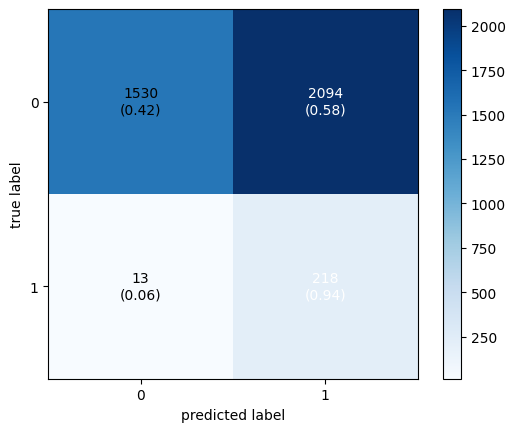

In [ ]:
print(classification_report(y_test, pred))
cm1 = confusion_matrix(y_test,pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

In [ ]:
'''
เมื่อลอง Train Model ด้วย Features ดังกล่าว พบว่า Accuracy ลดลงอย่างมากแม้ว่า ค่า Recall Class 1 และ Precision Class 0 จะเท่าเดิม
แต่ Recall ต่อ Class 0 กลับลดลงอย่างมากทำให้เพิ่มค่า False Positive จึงไม่เหมาะนำ Model ไปใช้งานจริง

'''

'\nเมื่อลอง Train Model ด้วย Features ดังกล่าว พบว่า Accuracy ลดลงอย่างมากแม้ว่า ค่า Recall Class 1 และ Precision Class 0 จะเท่าเดิม\nแต่ Recall ต่อ Class 0 กลับลดลงอย่างมากทำให้เพิ่มค่า False Positive จึงไม่เหมาะนำ Model ไปใช้งานจริง\n\n'

#### RFE

In [ ]:
from sklearn.feature_selection import RFE
XGB2 = xgb.XGBClassifier(eta=0.1, gamma=1, max_depth=5, enable_categorical=True,
                       tree_method='gpu_hist', n_estimators=1000,
                       reg_alpha=0.005)
model = RFE(XGB2, n_features_to_select=7, step=1)
model.fit(X_train, y_train)
model.support_

array([ True, False, False,  True, False, False, False, False, False,
       False,  True,  True,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
        True])

In [ ]:
X_train.columns[model.support_]

Index(['Month', 'Make', 'Age', 'Fault', 'PolicyType', 'Deductible', 'Year'], dtype='object')

In [ ]:
#Features From Importance Features
      ## >>>  'PolicyType', 'Age', 'Make', 'Fault', 'Month','AddressChange-Claim', 'RepNumber'
#Features From Permutation Importance
      ## >>>  'Fault', 'AddressChange-Claim', 'Age', 'Year', 'Month', 'Deductable', 'RepNumber'
#Features From RFE
      ## >>> 'Month', 'Make', 'Age', 'Fault', 'PolicyType', 'Deductible', 'Year'
'''
  เมื่อลองเปรียบเทียบดูก็จะเห็นว่า 7 features แรกที่ได้จากทั้งสองวิธีนั้นใกล้เคียงกัน
'''

'\n  เมื่อลองเปรียบเทียบดูก็จะเห็นว่า 7 features แรกที่ได้จากทั้งสองวิธีนั้นใกล้เคียงกัน\n'

In [ ]:
X_RFE_train = X_under_train[['Month', 'Make', 'Age', 'Fault', 'PolicyType', 'Deductible', 'Year']]
X_RFE_test = X_test[['Month', 'Make', 'Age', 'Fault', 'PolicyType', 'Deductible', 'Year']]

In [ ]:
XGB2.fit(X_RFE_train, y_under_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.1, eval_metric=None,
              feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
cross_validate(XGB2, X_RFE_train, y_under_train)

{'fit_time': array([0.5935719 , 0.75026774, 0.80524635, 0.84642863, 0.58701706]),
 'score_time': array([0.00991225, 0.00940657, 0.01264596, 0.00379801, 0.00370574]),
 'test_score': array([0.80144404, 0.75812274, 0.7833935 , 0.77617329, 0.79710145])}

In [ ]:
pred = XGB2.predict(X_RFE_test)

              precision    recall  f1-score   support

           0       0.99      0.61      0.76      3624
           1       0.13      0.93      0.23       231

    accuracy                           0.63      3855
   macro avg       0.56      0.77      0.49      3855
weighted avg       0.94      0.63      0.73      3855



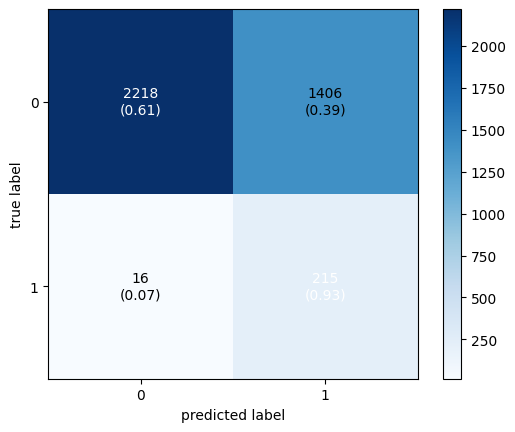

In [ ]:
print(classification_report(y_test, pred))
cm1 = confusion_matrix(y_test,pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

## Logistic Regression With Oversampling

### Full Features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, stratify=y)

In [ ]:
pipe = Pipeline(steps=[('ros', RandomOverSampler(random_state=99)),
                       ('standardscaler', StandardScaler()),
                       (('logisticregression', LogisticRegression(max_iter=5000)))])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('ros', RandomOverSampler(random_state=99)),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=5000))])

In [ ]:
cross_validate(pipe, X_train, y_train)

{'fit_time': array([0.05630374, 0.05508614, 0.05184126, 0.05195093, 0.05151653]),
 'score_time': array([0.00355577, 0.00348258, 0.00316787, 0.00304198, 0.00310993]),
 'test_score': array([0.61348898, 0.64461738, 0.61781236, 0.62991786, 0.61608301])}

In [ ]:
pipe_pred = pipe.predict(X_test)

              precision    recall  f1-score   support

           0       0.97      0.62      0.76      3624
           1       0.11      0.73      0.19       231

    accuracy                           0.63      3855
   macro avg       0.54      0.68      0.48      3855
weighted avg       0.92      0.63      0.73      3855



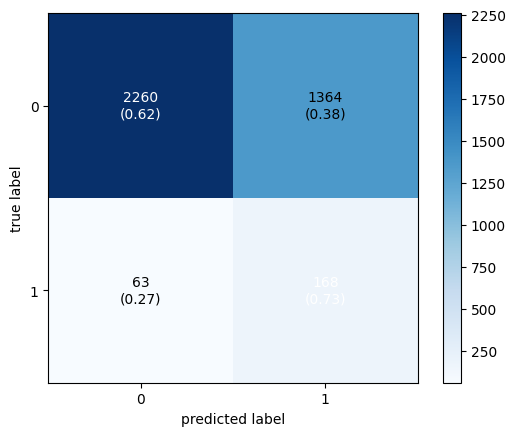

In [ ]:
print(classification_report(y_test, pipe_pred))
cm1 = confusion_matrix(y_test, pipe_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

### PCA 80%

In [ ]:
pipe = Pipeline(steps=[('standardscaler', StandardScaler()),
                      ('ros', RandomOverSampler(random_state=99)),
                      ('PCA', PCA(0.8)),
                      ('logisticregression', LogisticRegression(max_iter=5000))])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ros', RandomOverSampler(random_state=99)),
                ('PCA', PCA(n_components=0.8)),
                ('logisticregression', LogisticRegression(max_iter=5000))])

In [ ]:
cross_validate(pipe, X_train, y_train)

{'fit_time': array([0.10624743, 0.10002899, 0.06390858, 0.05695248, 0.09057307]),
 'score_time': array([0.01016116, 0.00847411, 0.00376916, 0.00403047, 0.00887632]),
 'test_score': array([0.58668396, 0.6104626 , 0.59143969, 0.59014267, 0.59922179])}

In [ ]:
pipe_pred = pipe.predict(X_test)

              precision    recall  f1-score   support

           0       0.96      0.59      0.73      3624
           1       0.09      0.62      0.15       231

    accuracy                           0.59      3855
   macro avg       0.52      0.60      0.44      3855
weighted avg       0.91      0.59      0.70      3855



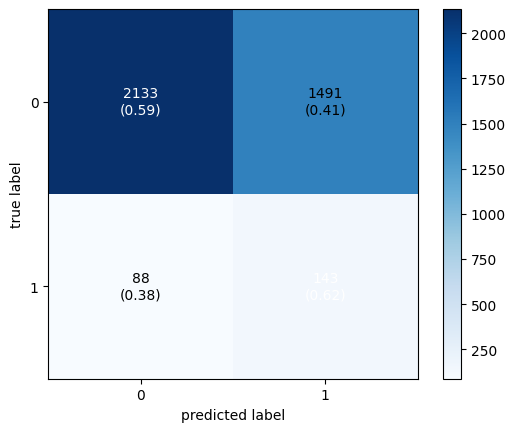

In [ ]:
print(classification_report(y_test, pipe_pred))
cm1 = confusion_matrix(y_test, pipe_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

### Features Selection

#### RFE

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, stratify=y)

In [ ]:
#scaler = StandardScaler().fit(X_train)

In [ ]:
#X_train_scaled = scaler.transform(X_train)

In [ ]:
# from sklearn.linear_model import LassoCV, RidgeCV
# from sklearn.feature_selection import RFECV

In [ ]:
# pipe = Pipeline(steps=[('ros', RandomOverSampler(random_state=99)),
#                        ('standardscaler', StandardScaler()),
#                        ('rfe', RFECV(LogisticRegression(max_iter=5000), cv=10))])

In [ ]:
# X_train

In [ ]:
ros = RandomOverSampler(random_state=99)
X_oversam_RFE, y_oversam_RFE = ros.fit_resample(X_train, y_train)

In [ ]:
from sklearn.feature_selection import RFE
lr1 = LogisticRegression(max_iter=5000)
model = RFE(lr1, n_features_to_select=7, step=1)
model.fit(X_oversam_RFE, y_oversam_RFE)
model.support_

array([False, False, False, False,  True, False, False, False,  True,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False,  True, False,  True, False,  True, False,
       False])

In [ ]:
X_oversam_RFE.columns[model.support_]

Index(['AccidentArea', 'Sex', 'Fault', 'PolicyType', 'PoliceReportFiled',
       'AgentType', 'AddressChange-Claim'],
      dtype='object')

In [ ]:
X_RFE_trainLR = X_oversam_RFE[['AccidentArea', 'Sex', 'Fault', 'PolicyType', 'PoliceReportFiled',
       'WitnessPresent', 'AgentType']]
X_RFE_test_LR = X_test[['AccidentArea', 'Sex', 'Fault', 'PolicyType', 'PoliceReportFiled',
       'WitnessPresent', 'AgentType']]

In [ ]:
lr1.fit(X_RFE_trainLR, y_oversam_RFE)

LogisticRegression(max_iter=5000)

In [ ]:
cross_validate(lr1, X_RFE_trainLR, y_oversam_RFE)

{'fit_time': array([0.06458235, 0.04835343, 0.05161142, 0.05744338, 0.04795837]),
 'score_time': array([0.00285006, 0.00267363, 0.00227904, 0.00264931, 0.00241494]),
 'test_score': array([0.71770115, 0.70154058, 0.71717636, 0.71188779, 0.71372729])}

In [ ]:
pred = lr1.predict(X_RFE_test_LR)

              precision    recall  f1-score   support

           0       0.98      0.64      0.77      3624
           1       0.12      0.76      0.21       231

    accuracy                           0.65      3855
   macro avg       0.55      0.70      0.49      3855
weighted avg       0.93      0.65      0.74      3855



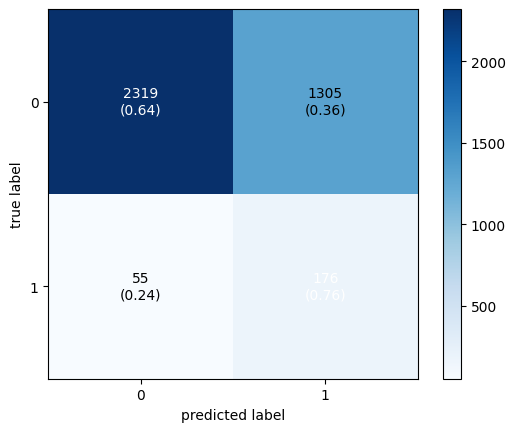

In [ ]:
print(classification_report(y_test, pred))
cm1 = confusion_matrix(y_test, pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

#UMAP
เมื่อลองใช้เทคนิคการลดมิติ UMAP แล้ว plot ออกมาเป็นกราฟ 2 มิติ

จะเห็นได้ว่าข้อมูลทั่ง 2 คลาสกระจายปนกันไปทั้งหมด ทำให้เป็นการยาก

ที่โมเดลจะแยก Farud และ Non-Fraud ออกมาได้อย่างเด็ดขาด

In [ ]:
!pip install umap-learn

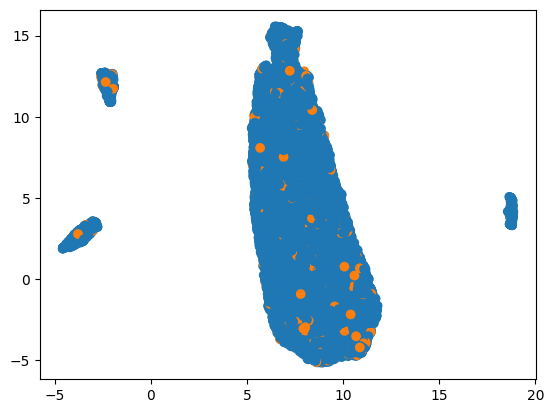

In [ ]:
import umap.umap_ as umap
manifold = umap.UMAP()
X_projected = manifold.fit_transform(X_onehot)
plt.scatter(X_projected [:, 0], X_projected [:, 1], c=plt.cm.tab10(y_onehot))
     

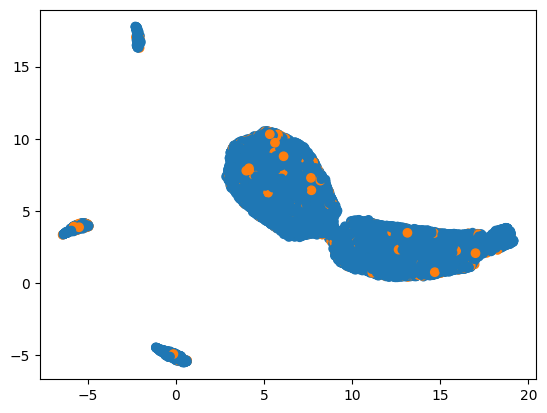

In [ ]:
import umap.umap_ as umap
manifold = umap.UMAP(n_neighbors=50)
X_projected = manifold.fit_transform(X_onehot)
plt.scatter(X_projected [:, 0], X_projected [:, 1], c=plt.cm.tab10(y_onehot))

Graph is not fully connected, spectral embedding may not work as expected.
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!


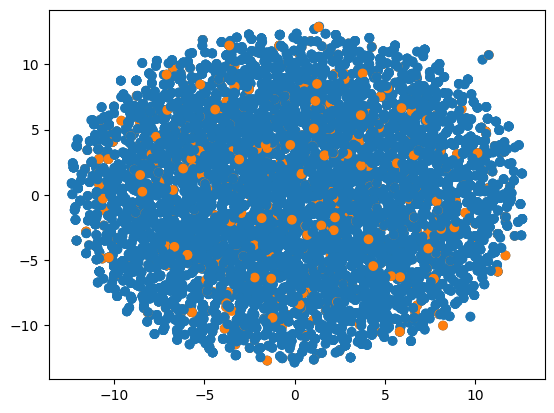

In [ ]:
import umap.umap_ as umap
manifold = umap.UMAP(n_neighbors=2)
X_projected = manifold.fit_transform(X)
plt.scatter(X_projected [:, 0], X_projected [:, 1], c=plt.cm.tab10(y))

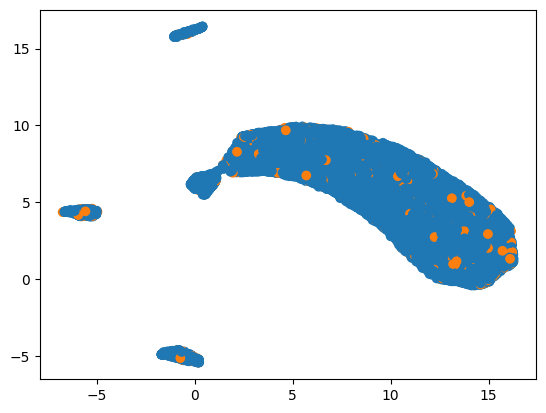

In [ ]:
import umap.umap_ as umap
manifold = umap.UMAP(n_neighbors=30)
X_projected = manifold.fit_transform(X_onehot)
plt.scatter(X_projected [:, 0], X_projected [:, 1], c=plt.cm.tab10(y_onehot))

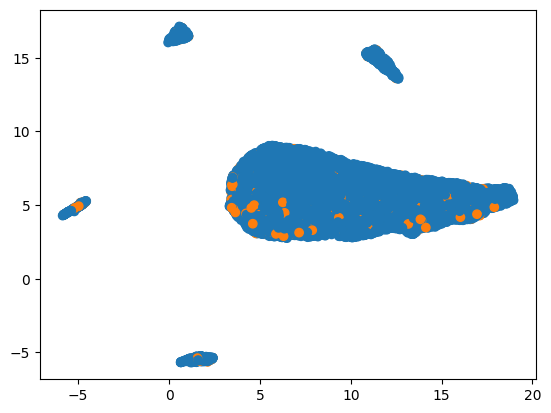

In [ ]:
import umap.umap_ as umap
manifold = umap.UMAP()
X_projected = manifold.fit_transform(X)
plt.scatter(X_projected [:, 0], X_projected [:, 1], c=plt.cm.tab10(y))
     

Graph is not fully connected, spectral embedding may not work as expected.
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!


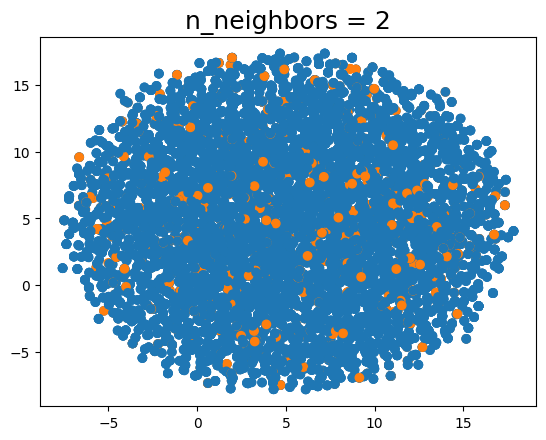

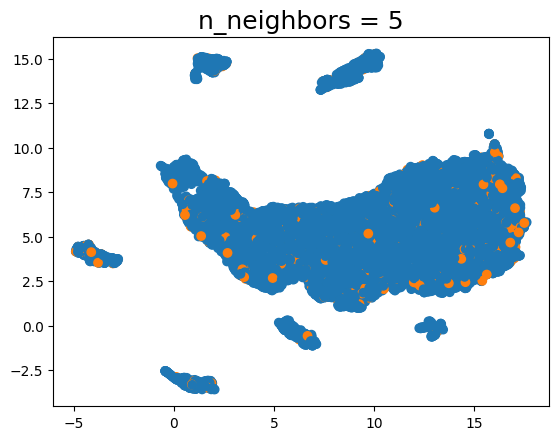

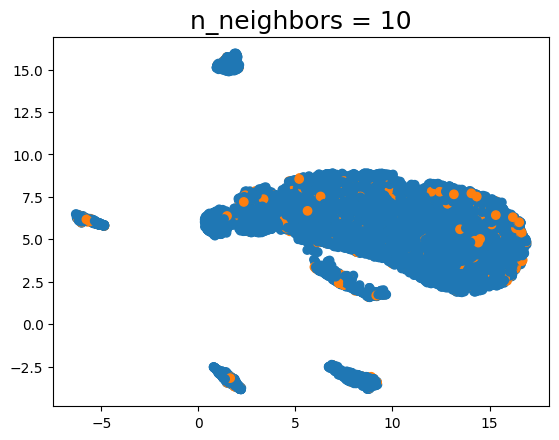

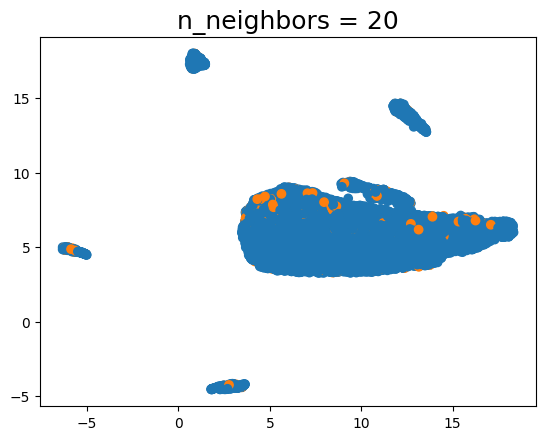

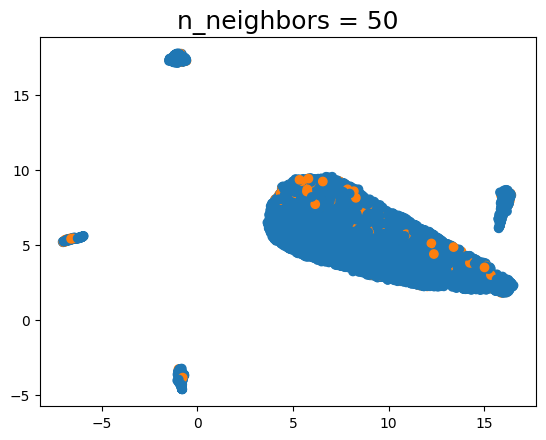

In [ ]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(X);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=df_drop)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=plt.cm.tab10(y))
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=df_drop, s=100)
    plt.title(title, fontsize=18)
for n in (2, 5, 10, 20, 50):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

# Conclusion

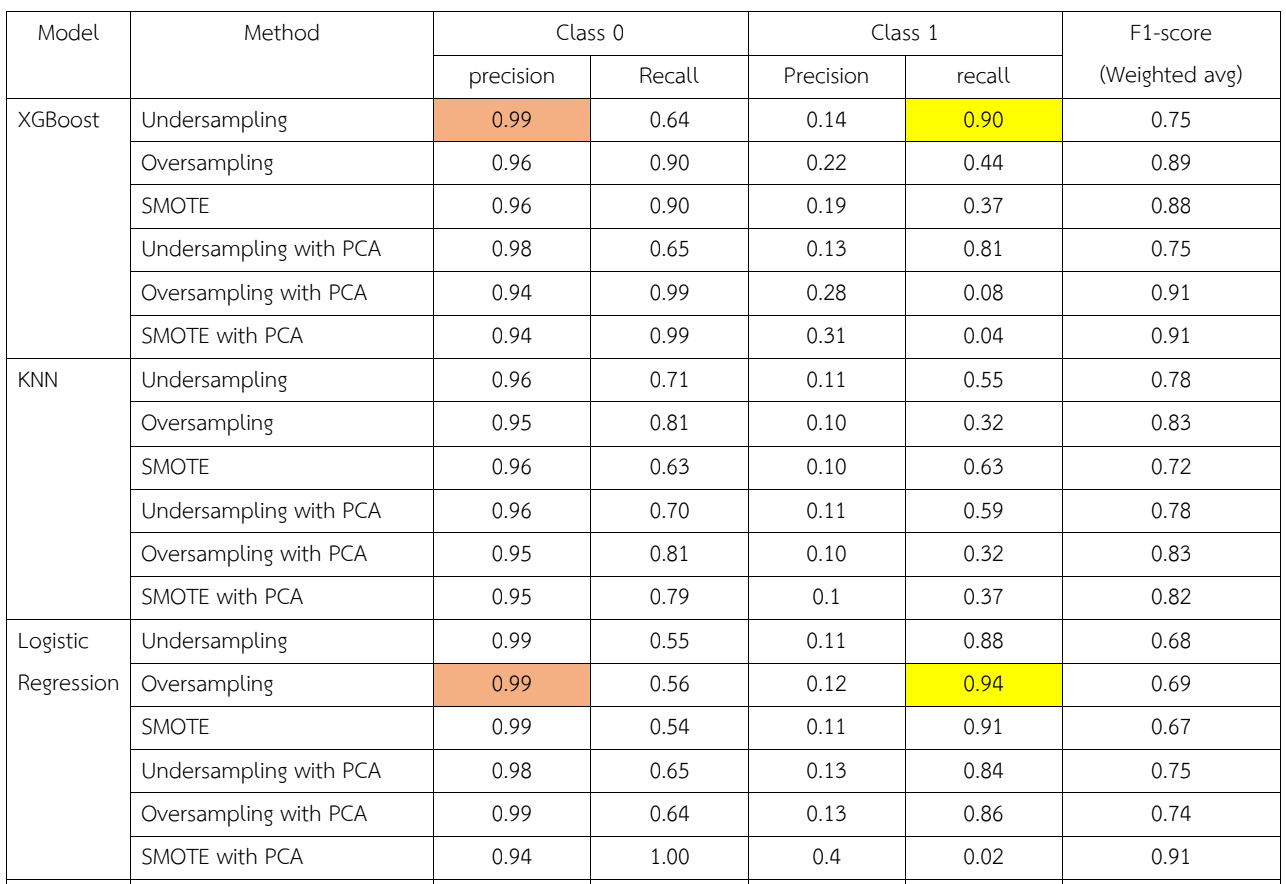

**Model Selection**

โดยสรุปแล้วจากการทดลองทั้งหมด เป็นเรื่องยากที่จะแยก Farud ออกจาก Not Fraud อย่างเด็ดขาด เนื่องจากปัญหา Imbalnaced class แม้ว่าจะพยายามแก้ปัญหาด้วยวิธีการต่างๆ ทั้ง SMOTE , Ovesampling, Undersampling พบว่า Model ที่น่าสนใจคือ

1. XGBoost with UnderSampling
2. LogisticRegression with Oversampling

เนื่องจากว่าเมื่อดูที่ Class 0 มีค่า Precision 0.99 นั้น หมายถึงหาก Model 
ทายว่าเป็น Class 0 มีโอกาสถึง 99% ที่จะเป็น Class 0 จริง และค่า Recall 0.90 และ
0.94 ตามลำดับนั่น หมายความว่าสามสามารถ Detect Fraud ใน Dataset ทั้งหมดได้ถึง
90% และ 94% ตามลำดับ 

หากต้องเลือก Model เพื่อนำไปใช้งานจริง อาจไม่สามารถใช้งานเดี่ยวๆได้อาจจะต้องใช้วิธี Man-Machine Combination
 เพราะถึงแม้ว่าจะสามารถ Detect Fraud ได้ถึง 90%-94% จากทั้งหมด 
 แต่ Model ก็ยังสร้าง False Positive Prediction ออกมาจำนวนหนึ่งด้วย

อาจจะต้องใช้ Model เป็นตัว Screening คือ ถ้า Model Predict ว่า Non-Fraud ให้คิดไว้ก่อนว่าเป็น Non-Fraud จริงซึ่งในกลุ่มนี้ Model จะให้ False Negative ประมาณ 6% แต่ถ้า Model Predict ว่าเป็น Fraud กลุ่มนี้จะต้องผ่านกาคัดกรองโดยละเอียดอีกครั้งโดยมนุษย์ ซึ่งจะช่วยลดงานของมนุษย์ทำให้ Focus กับบางกลุ่มได้มากขึ้น 



**Full Features VS PCA VS Features Selection**

เมื่อพยายามใช้ Features Seletion พบว่าใช้ประมาณ 7 Features 

เป็นจำนวนน้อยที่สุดที่จะสามารถคงความแม่นยำและความถูกต้อง

ให้เท่ากับหรือใกล้เคียงการใช้ Fulll Features

เมื่อใช้ PCA พบว่าโดยส่วนใหญ้ความถูกต้องและความแม่นยำ

ของ Model ลดต่ำลงเนื่องจากคาดว่าเป็นการลดมิติของข้อมูลลงไป

ในภาพรวมซึ่งแตกต่างกับการเลือก Features Selection

ซึ่งเป็นการพยายามเลือกเฉพาะ Features ที่มีผลต่อ Prediction เยอะกว่า

ออกมาใช้



